# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов.
В нём можно быстро узнать рыночную стоимость своего автомобиля.
В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

**Заказчику необходима модель для определения стоимости. Максимальное целевое отклонение по стоимости (RSME) - 2500.**

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**
**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
Price — цена (евро)


В процессе будем использовать простые модели (линейной регрессии и регрессионный случайный лес) и модели бустинга (LightGBM и CatBoost).

## 1. Подготовка данных

Загрузим данные и необходимые библиотеки.

In [1]:
import isort

sorted_code = isort.code(
    "import matplotlib.pyplot as plt \n import numpy as np \n import os \n import pandas as pd\n" \
    "from sklearn.linear_model import LinearRegression \n from sklearn.metrics import mean_squared_error \n"\
    "from sklearn.model_selection import train_test_split \n import seaborn as sns \n import warnings \n" \
    "from sklearn.model_selection import cross_val_score \n from sklearn.tree import DecisionTreeRegressor \n"\
    "from sklearn.ensemble import RandomForestRegressor \n from sklearn.metrics import mean_absolute_error \n"\
    "from sklearn.model_selection import GridSearchCV \n from sklearn.dummy import DummyRegressor"\
    "from sklearn.metrics import make_scorer \n from catboost import CatBoostRegressor"\
    "from sklearn.preprocessing import StandardScaler"
) 
print(sorted_code)

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import (CatBoostRegressorfrom, StandardScaler, import,
                      sklearn.preprocessing)
from sklearn.dummy import (DummyRegressorfrom, import, make_scorer,
                           sklearn.metrics)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.tree import DecisionTreeRegressor



In [2]:
import os
import time 
import warnings

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from catboost import CatBoostRegressor

from imblearn.pipeline import make_pipeline as make_pipeline_imb

from joblib import Parallel, delayed

from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor
from sklearn.compose import make_column_transformer #для OHE sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split, cross_validate, RandomizedSearchCV)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle

In [3]:
RANDOM_STATE = 42

In [4]:
pth0 = 'https://code.s3.yandex.net/datasets/autos.csv'

try:
    df = pd.read_csv(pth0)
except:
    print("Проверьте правильность пути к датасету")

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


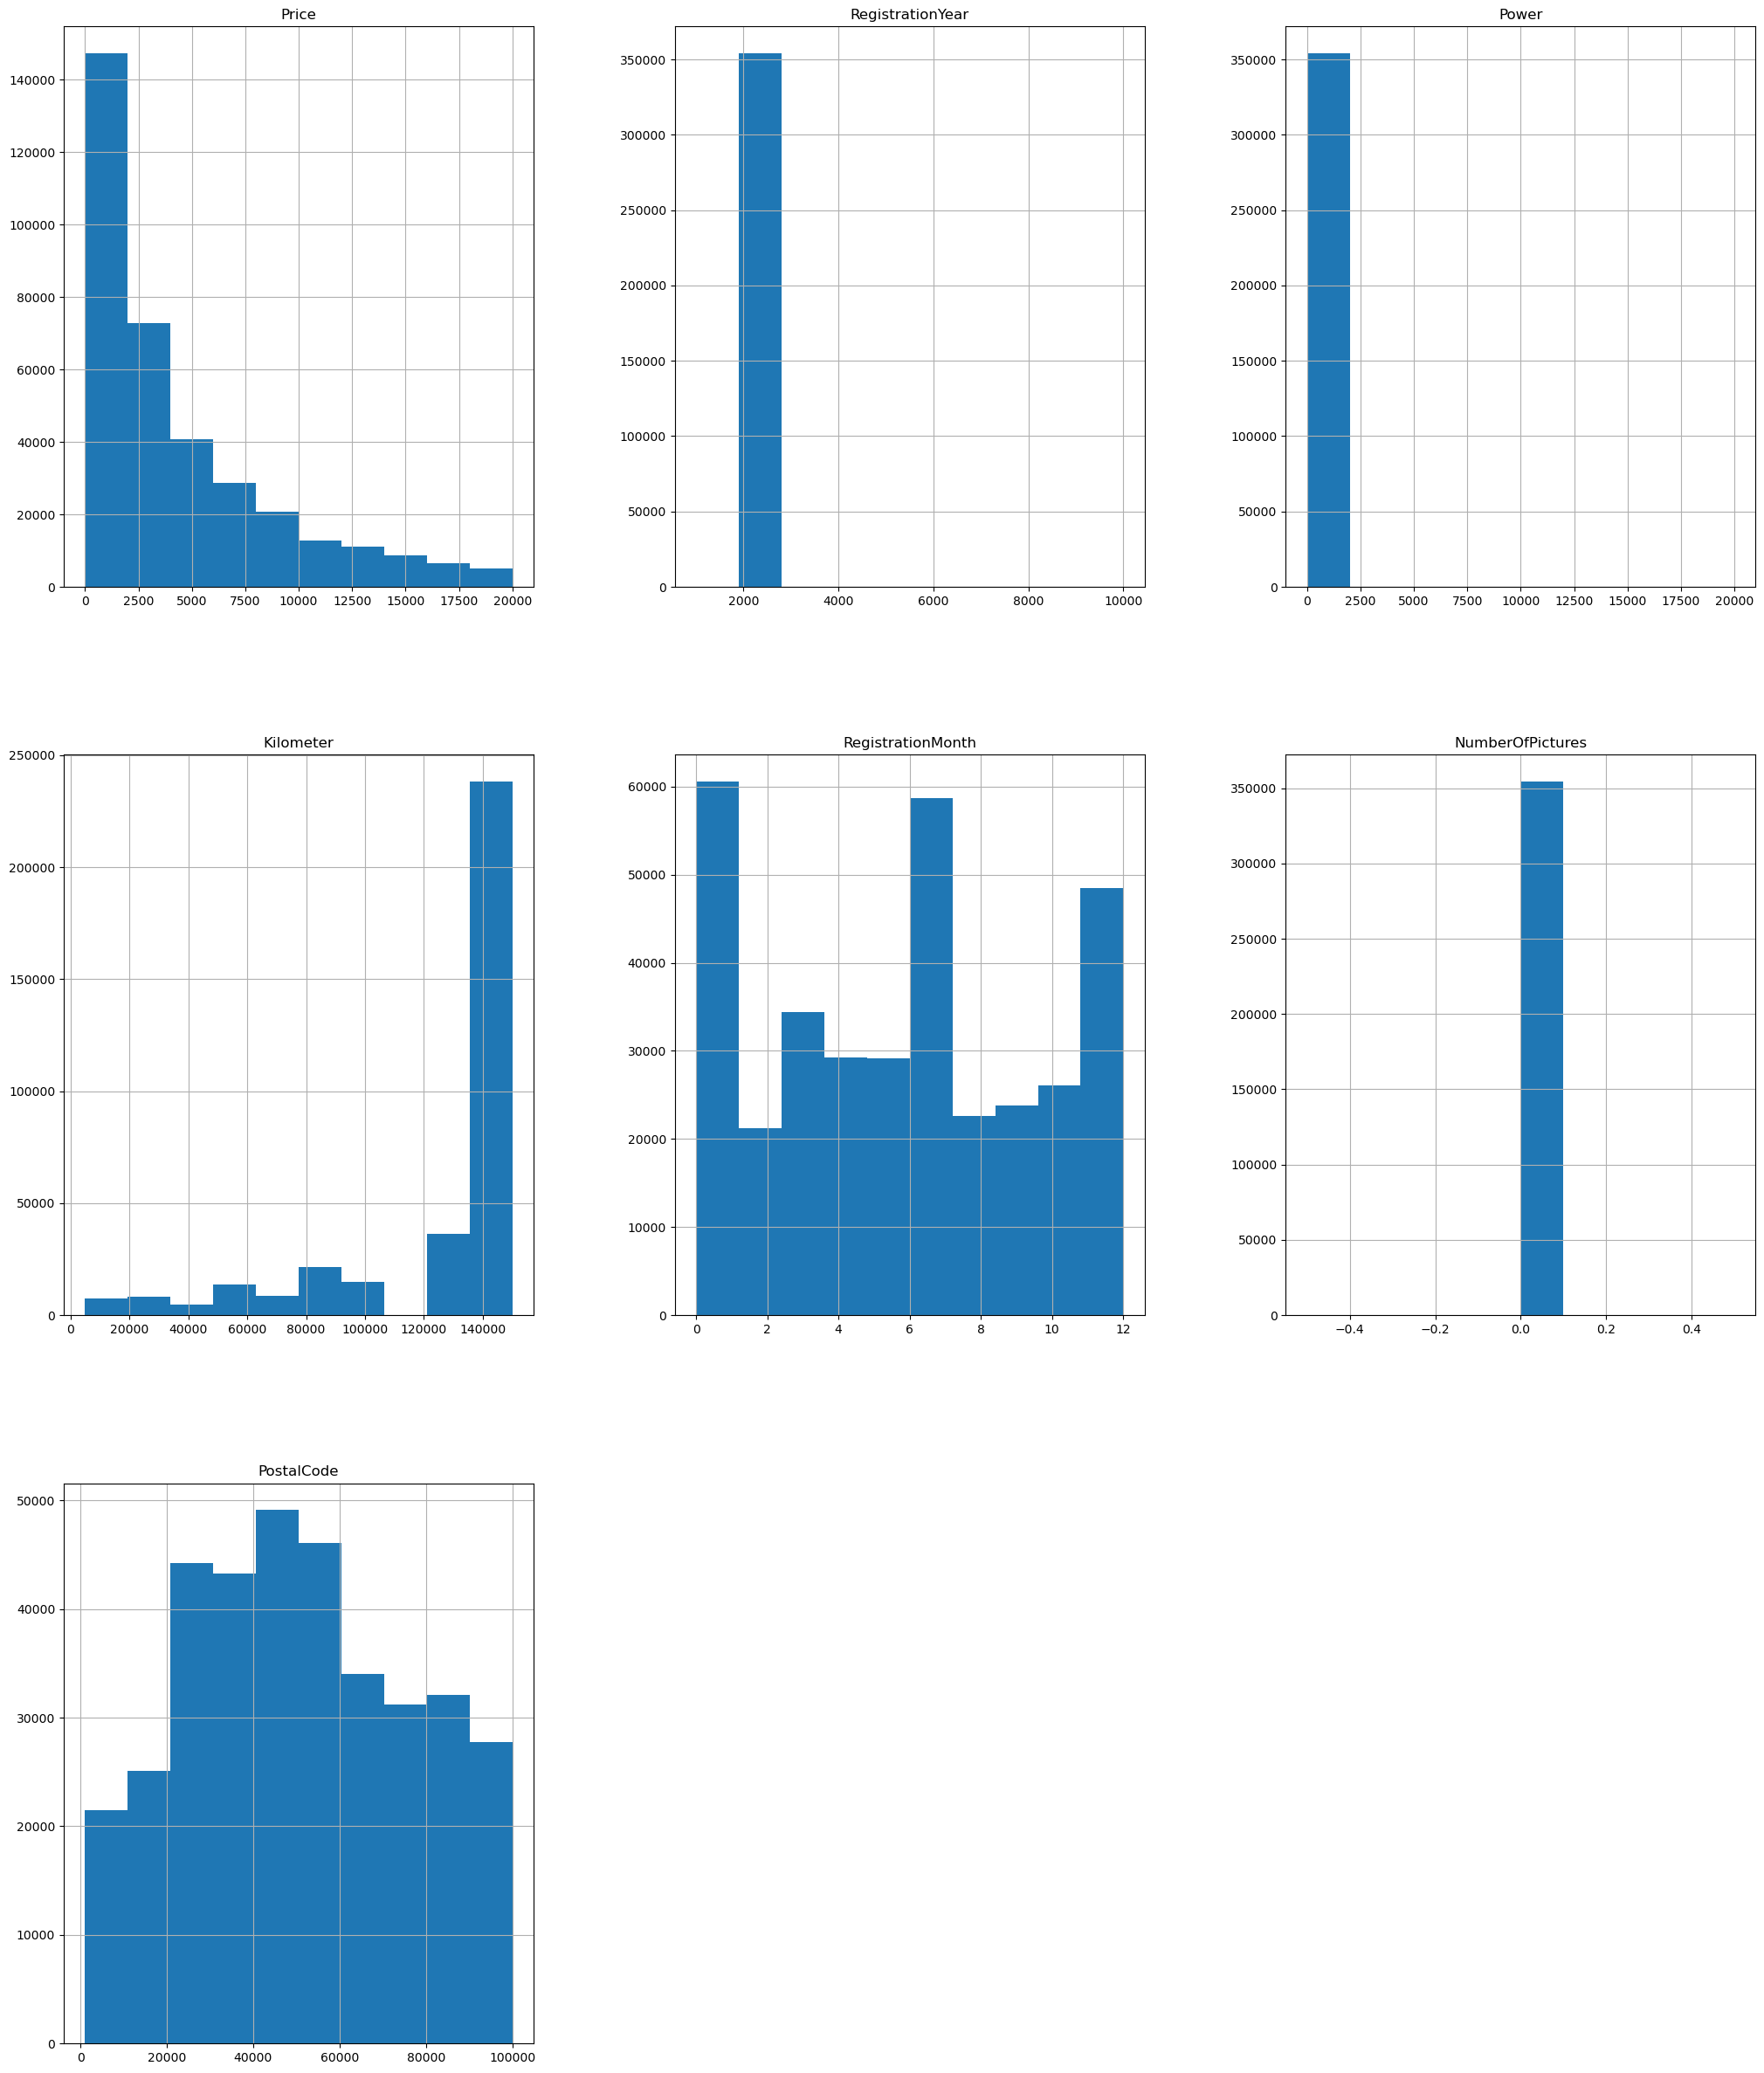

In [8]:
df.hist(figsize=(25, 30))
plt.show()

In [9]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


Как видно из указанных выше таблиц, имеются пропуски в таблице. Также вызывает вопрос проблем с рассчетом коэффициентов корреляции Пирсона в отношении количества фотографий, ведь в данном столбце нет пропусков и корректный формат. Изучим его чуть внимательнее перед прочей обработкой, но перед этим приведем вид названий столбцов к общепринятому (уберем прописные буквы)

In [10]:
df.columns = df.columns.map(lambda x: x.lower())
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [11]:
df['numberofpictures'].unique()

array([0])

Итак, данный столбец фактически пустой, удалим его за ненадобностью для экономии ресурсов. Также сразу удалим столбец с месяцем регистрации, т.к. он не несет никакой полезной информации, для оценки стоимости автомобиля необходима и достаточна информация о году выпуска, в данном случае - году регистрации.

In [12]:
df.drop(['numberofpictures', 'registrationmonth'], axis=1,inplace=True)
df.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,datecreated,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21


Также обращает на себя внимание распределение цены, сильно скошенное вправо и при укрупненном графике стремящееся к 0. Изучим столбец внимательнее.

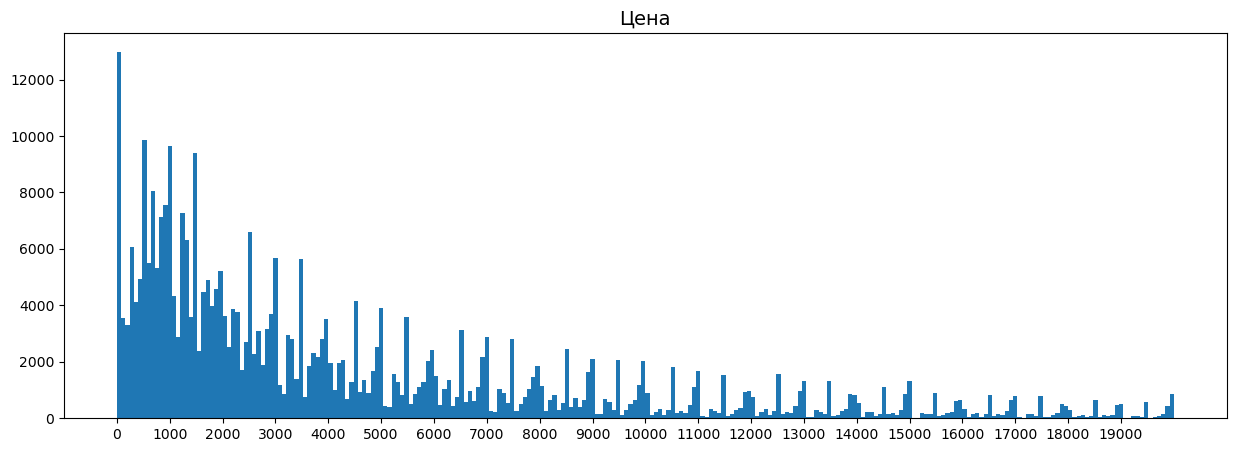

In [13]:
plt.figure(figsize=[15,5])
plt.hist(df['price'], bins=250)
plt.xticks(range(0,20000,1000))
plt.title("Цена", fontsize=14)
plt.show()

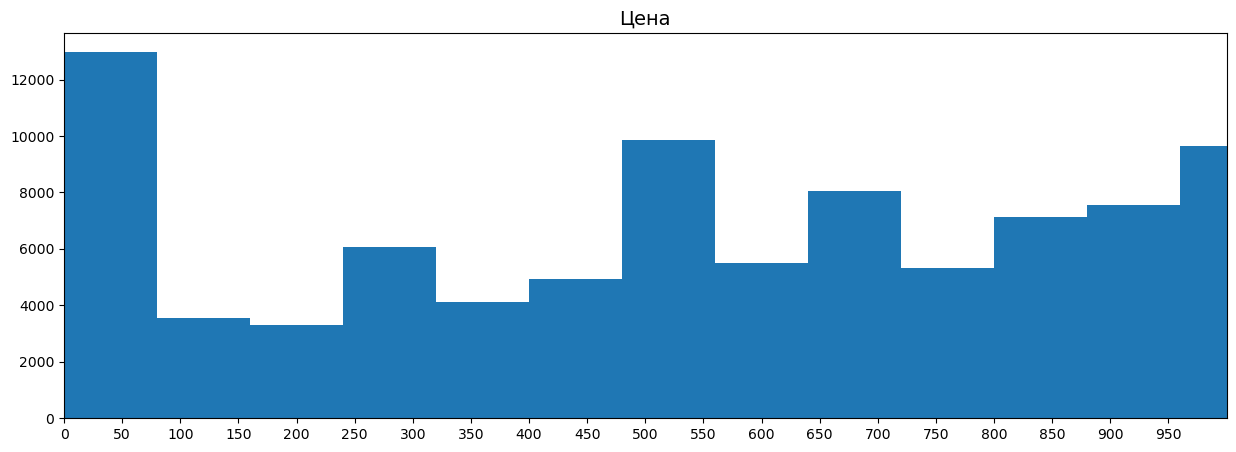

In [14]:
plt.figure(figsize=[15,5])
plt.hist(df['price'], bins=250)
plt.xlim(0,1000)
plt.xticks(range(0,1000,50))
plt.title("Цена", fontsize=14)
plt.show()

Как становится видно при ближайшем рассмотрении, большое количество автомобилей находится по цене в диапазоне от 0 до 75 долларов. Это нереалистичный сценарий, при этом следует отметить, что такие машины составляют свыше 12 000 позиций, т.е. треть выборки.
Предположим, что так мало могут стоить очень старые и ремонтированные (скорее всего, неоднократно) машины. Проверим эту гипотезу. Перед этим заполним пропуски в столбце ремонта заглушкой "no data".

Создадим копию исходного датасета и будем с ним работать над очисткой.

<div class="alert alert-block alert-success"; style="border-left: 6px solid green">
<b>Успех ✔️</b>
       
Здорово, что не забываешь про оформление графиков!
    
</div>


In [15]:
df0=df

In [16]:
df0['repaired'] = df0['repaired'].fillna('no_data')
df0.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,datecreated,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,no_data,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no_data,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21


In [17]:
df0.groupby('repaired').agg(
    {'price': ['count','median'],'registrationyear': ['median'],'kilometer': ['median'],'power':['median']})

price         registrationyear kilometer  power
           count  median           median    median median
repaired                                                  
no        247161  3690.0           2004.0  150000.0  110.0
no_data    71154  1390.0           2001.0  150000.0   75.0
yes        36054   900.0           2001.0  150000.0  101.0

In [18]:
df0.query('price <=100').groupby('repaired').agg(
    {
        'price': ['count','median'],
        'registrationyear': ['median'],
        'kilometer': ['median'],
        'power':['median'],
        'postalcode':['mean']
    }
)

price        registrationyear kilometer  power    postalcode
         count median           median    median median          mean
repaired                                                             
no        4097    0.0           2000.0  150000.0   95.0  43102.546742
no_data   7287    0.0           2000.0  150000.0    0.0  47169.816523
yes       2961    0.0           1999.0  150000.0   75.0  46646.401216

In [19]:
df0['registrationyear'].min()

1000

Итак, предположение об "очень старых отремонтированных машинах" не подтвердилось полностью: скорее речь идет о в принципе отремонтированных машинах, но они все равно медианно (т.е. без учета "выбросов") стоят в районе 900 евро.

Попробуем посмотреть, какие еще отличительные особенности у машин "за 100".

In [20]:
df0.query('price <=100').describe().T

,count,mean,std,min,25%,50%,75%,max
price,14345.0,12.223005,30.026282,0.0,0.0,0.0,0.0,100.0
registrationyear,14345.0,2010.342070,292.084049,1000.0,1996.0,2000.0,2005.0,9999.0
power,14345.0,74.749948,216.532986,0.0,0.0,60.0,115.0,15016.0
kilometer,14345.0,121350.296270,51176.172295,5000.0,125000.0,150000.0,150000.0,150000.0
postalcode,14345.0,45900.145068,26794.462864,1069.0,25712.0,44339.0,65614.0,99998.0


In [21]:
df0.query('price <=100')['price'].count()/len(df)

0.04048040319553911

Итого данные машины не выделяются ничем, кроме того, что на них нет цены, они указаны по всем странам и с разными данными по мощности двигателей (хотя следует отметить, что о четверти таких машин отсутствуют и данные по мощности). Эти данные составляют 4% всех записей, поэтому, а также в связи с тем, что пропуски касаются целевого столбца, где наши допущения и попытки заполнить данные по неким средним/ медианным значениям могут исказить результат, считаем необходимым удалить данные записи.

In [22]:
df0 = df0.loc[df0['price']>=100]
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
price,341055.0,4588.861052,4514.844700,100.0,1200.0,2900.0,6500.0,20000.0
registrationyear,341055.0,2003.955303,69.811742,1000.0,1999.0,2003.0,2008.0,9999.0
power,341055.0,111.396197,188.373379,0.0,70.0,105.0,143.0,20000.0
kilometer,341055.0,128497.764290,37243.801610,5000.0,125000.0,150000.0,150000.0,150000.0
postalcode,341055.0,50695.796983,25733.510931,1067.0,30453.0,49525.0,71229.0,99998.0


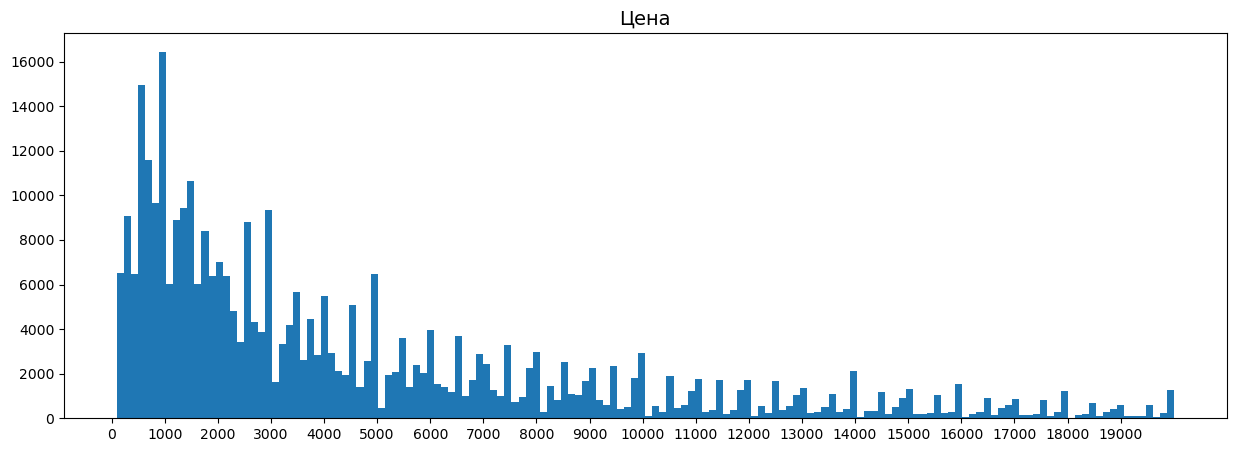

In [23]:
plt.figure(figsize=[15,5])
plt.hist(df0['price'], bins=150)
plt.xticks(range(0,20000,1000))
plt.title("Цена", fontsize=14)
plt.show()

Видно, как после удаления сдвинулся в сторону "нормального" вида распределения график. На данном этапе оставим цену в таком виде, проанализируем остальные признаки.

Начнем не по порядку, а с года регистрации автомобиля, т.к. при анализе цены уже обратила на себя ошибка с данными по году (1000 год регистрации автомобиля, даже с 1 лошадиной силой, вряд ли возможен).

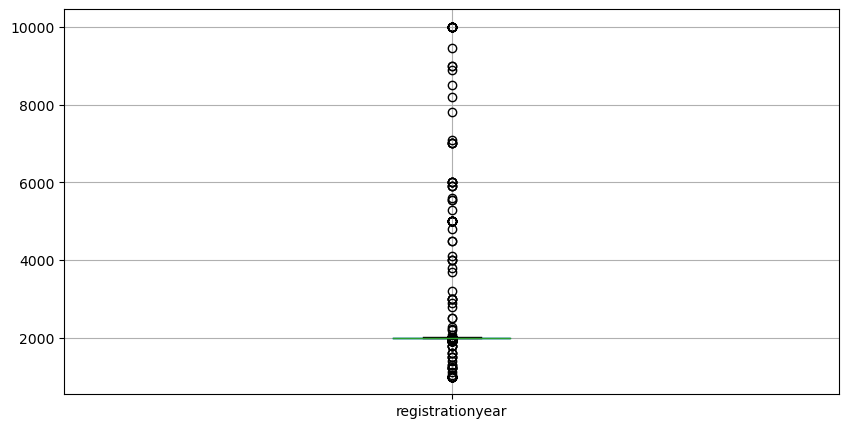

In [24]:
plt.figure(figsize=(10,5))
df0.boxplot('registrationyear')
plt.show()

В данном столбце явно имеется значительное количество некорретных данных, поэтому определим год регистрации объявлений для последующего удаления всех объявлений "из будущего", т.е. таких, где год регистрации позднее года размещения объявления. В данном случае снова выбрано удаление как способ приведения данных в соответствие, т.к. восстановление года регистрации автомобиля по косвенным признакам невозможно или крайне трудоемко, при этом год как определитель возраста автомобиля имеет важное значение для предсказания цены.

Переведем столбец с датой создания анкеты в тип даты и извлечем из него в новый столбец год создания анкеты для проверки.

In [25]:
df0['datecreated']= pd.to_datetime(df0['datecreated'],format='%Y.%m.%d %H:%M:%S')
df0['year_creation'] = pd.DatetimeIndex(df0['datecreated']).year
df0['year_creation'].unique()

/var/folders/4b/1pgdq9hd0gvcfdcz_7c2bbvc0000gn/T/ipykernel_63609/3088139983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['datecreated']= pd.to_datetime(df0['datecreated'],format='%Y.%m.%d %H:%M:%S')
/var/folders/4b/1pgdq9hd0gvcfdcz_7c2bbvc0000gn/T/ipykernel_63609/3088139983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['year_creation'] = pd.DatetimeIndex(df0['datecreated']).year


array([2016, 2015, 2014])

Удалим объявления, где год регистрации автомобиля позднее, чем год размещения анкеты, также удалим объявления, в которых год выпуска автомобиля ранее 1966 года (40 лет на дату позднейшего объявления), т.к. автомобили старше уже скорее относятся к раритетам, которые могут иметь как коллекционное значение, так и быть крайне изношенными и не соответствующими большей части предложения.

In [26]:
df0 = df0.query('registrationyear >=1976 & registrationyear <= year_creation')
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
price,325160.0,4618.810979,4529.188920,100.0,1200.0,2950.0,6600.0,20000.0
registrationyear,325160.0,2002.867124,6.144522,1976.0,1999.0,2003.0,2007.0,2016.0
power,325160.0,112.580853,183.595760,0.0,73.0,105.0,143.0,20000.0
kilometer,325160.0,128668.732316,36944.968577,5000.0,125000.0,150000.0,150000.0,150000.0
postalcode,325160.0,50793.883682,25745.740916,1067.0,30459.0,49635.0,71334.0,99998.0
year_creation,325160.0,2015.999917,0.009444,2014.0,2016.0,2016.0,2016.0,2016.0


In [27]:
print("Сокращение датасета на текущем этапе от начального значения {0:.2%}".format(1-len(df0)/len(df)))

Сокращение датасета на текущем этапе от начального значения 8.24%


После текущей очистки год регистрации у нас пришел в более адекватный вид, значения диапазона цен сдвинулись незначительно в большую сторону. Размер сокращения датасета некритичен.

Проверим столбец с данными по кузову. Перед этим напишем короткую функцию для оптимизации дальнейшего кода.

In [28]:
# функция для знакомства с категориальными признаками

def intro_categ(df,column, column_name): 
    #название столбца нужно писать в дательном падеже ("по типу кузова") для графика
    
    print ("Уникальные значения:",df[column].unique())# отбираем уникальные значения
     
    # сделаем сразу "заглушку" дл пропущенных значений
    df[column] = df[column].fillna('no_data')
    # нарисуем график 
    g = df.pivot_table(
    index = 'registrationyear',
    columns = column,
    values = 'price',
    aggfunc='count').plot.bar(rot=0, grid=False,figsize = (20,10),stacked = True)
    
    #название столбца нужно писать в дательном падеже
    
    g.axes.set_title("Распределение цен машин в разрезе по годам {}".format(column_name), fontsize=14)
    
    g.set_xlabel("Год", fontsize=10)
    g.set_ylabel("Количество записей, шт", fontsize=10)
    plt.show()
    
    #считаем долю пропущенных значений
    print ("Доля пропущенных значений {0:.2%}:".format(df[(df[column] == 'no_data')]['price'].count()/len(df)))
    print ("Количество пропущенных значений:",df[(df[column] == 'no_data')]['price'].count())

Уникальные значения: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


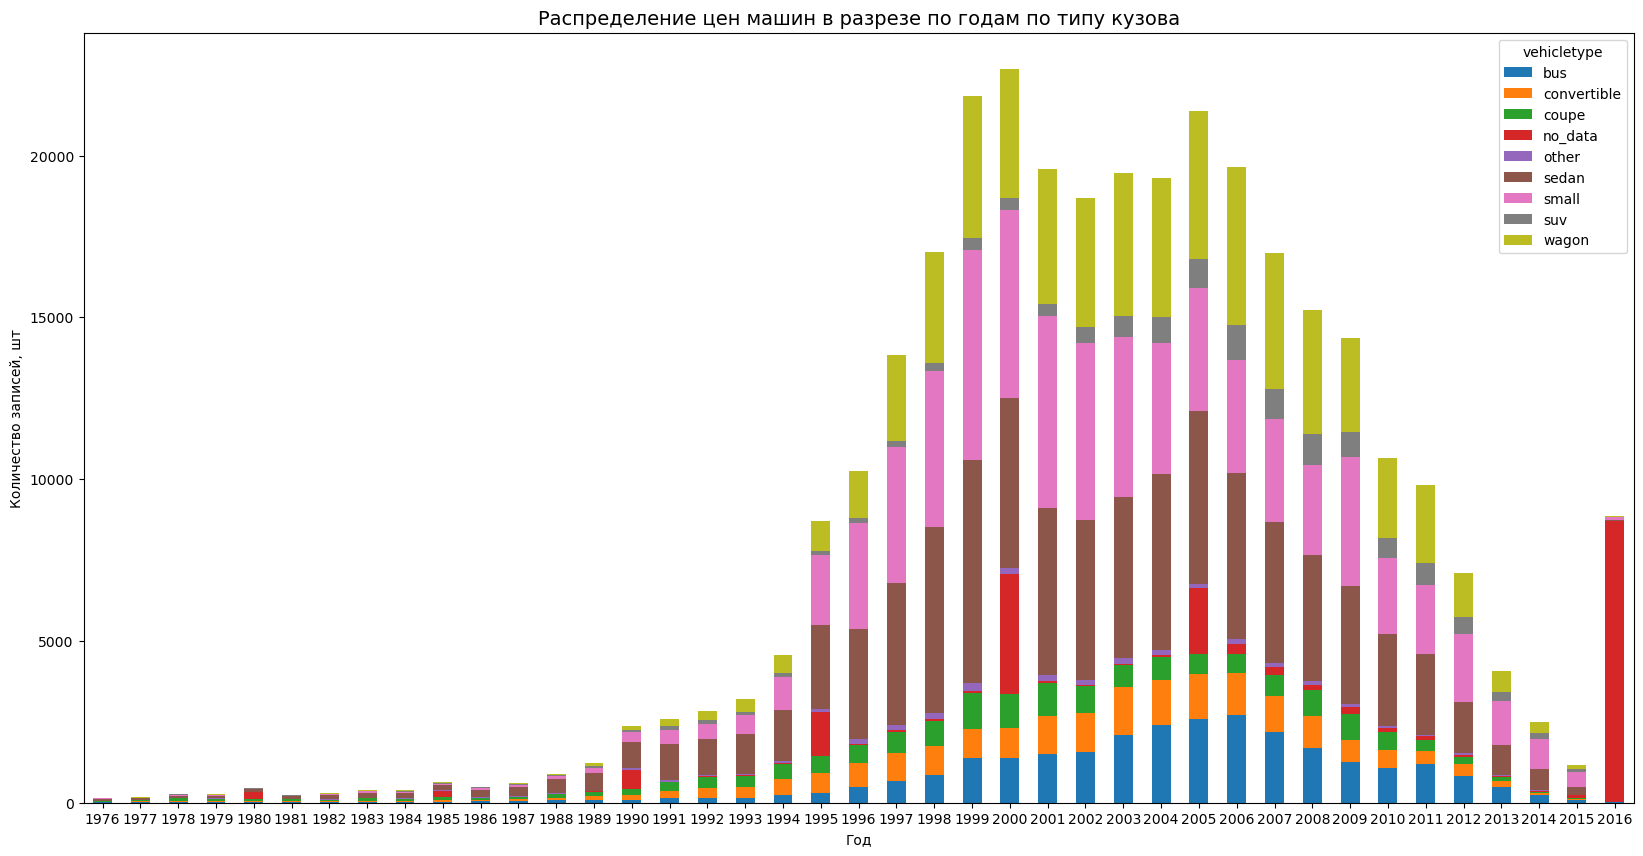

Доля пропущенных значений 5.75%:
Количество пропущенных значений: 18699


In [29]:
intro_categ(df0,'vehicletype', "по типу кузова")

Все виды кузовов распределены более-ни менее равномерно, в лидерах универсал ("wagon"), седаны и автобусы. Обращает на себя внимание то, что наибольшая часть значений установленной временной "заглушки" в виде "no_data" саккумулировались на 2016 году и в принципе практически все данные 2016 года - это автомобили без данных о кузове. С высокой долей вероятности можно утверждать, что эти данные ошибочны, в связи с чем они подлежат удалению.

In [30]:
df0.query('registrationyear == 2016').groupby('vehicletype')['price'].count()

vehicletype
bus               9
convertible       3
coupe            13
no_data        8686
other             7
sedan            20
small            83
suv              11
wagon            15
Name: price, dtype: int64

In [31]:
df0.query('vehicletype == "no_data"').groupby('registrationyear')['price'].count()

registrationyear
1977       1
1980     218
1985     205
1986       4
1988       3
1989       5
1990     588
1991      13
1992       7
1993      11
1994      12
1995    1352
1996      37
1997      69
1998      62
1999      72
2000    3708
2001      46
2002      36
2003      36
2004      56
2005    2040
2006     307
2007     241
2008     179
2009     220
2010     125
2011     116
2012      73
2013      46
2014      39
2015      86
2016    8686
Name: price, dtype: int64

В остальных случаях проверим, насколько выбивается средняя цена на автомобили без данных о кузове и с данными.

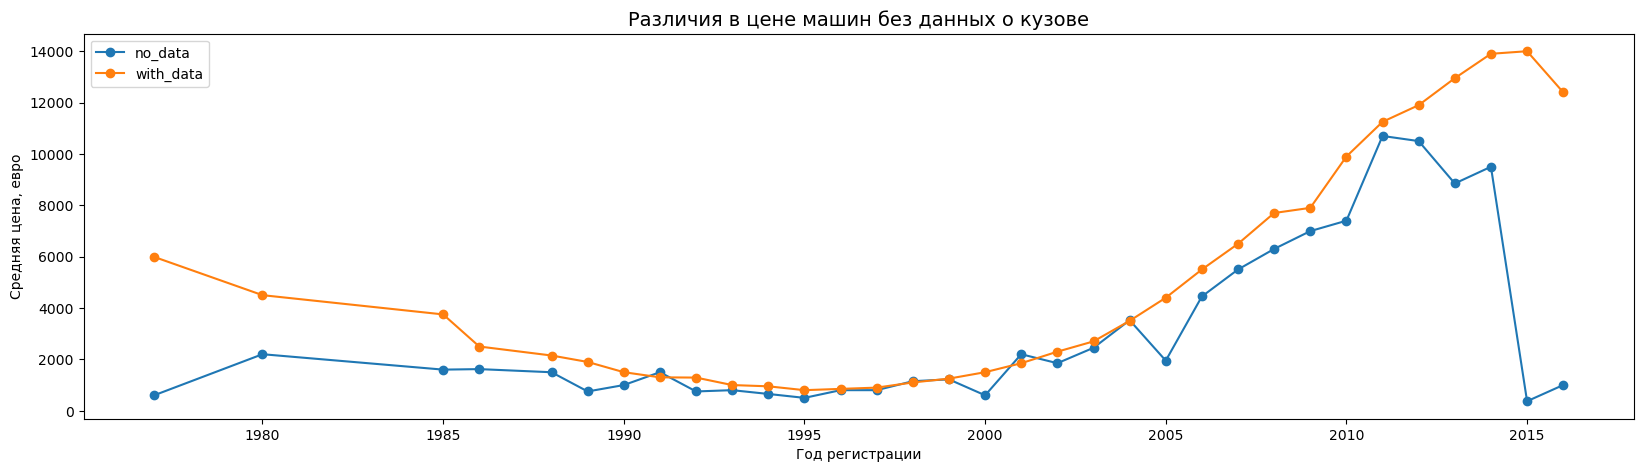

In [32]:
temp = pd.DataFrame(columns = ['no_data', 'with_data'])
temp['no_data'] = df0.query('vehicletype == "no_data"').groupby('registrationyear')['price'].median()
temp['with_data'] = df0.query('vehicletype != "no_data"').groupby('registrationyear')['price'].median()

g=temp.plot(style='o-', figsize = (20,5))

g.axes.set_title("Различия в цене машин без данных о кузове", fontsize=14)
g.set_xlabel("Год регистрации", fontsize=10)
g.set_ylabel("Средняя цена, евро", fontsize=10)
plt.show()

Как можно видеть из графика выше, медианная цена на машины без данных о кузове большую часть времени лежит ниже медианной цены на машины с указанным видом кузова, но в целом тренд после 1980 и до 2010 сходен, однако после идет резкий разрыв в цене. Кроме того, данные авто несколько раз "проваливаются" в цене в 2000, 2005 и 2010 гг по сравнению с прочим трендом.
Учитывая, что абсолютное большинство данных о таких машинах относятся к 2016 году, в котором наблюдается также и максимальный разрыв с основным трендом цены, считаем необходимым исключить все такие данные.

In [33]:
df0 = df0.query('vehicletype != "no_data"')
print("Сокращение датасета на текущем этапе от начального значения {0:.2%}".format(1-len(df0)/len(df)))

Сокращение датасета на текущем этапе от начального значения 13.52%


Проверим столбец gearbox.

Уникальные значения: ['manual' 'auto' nan]


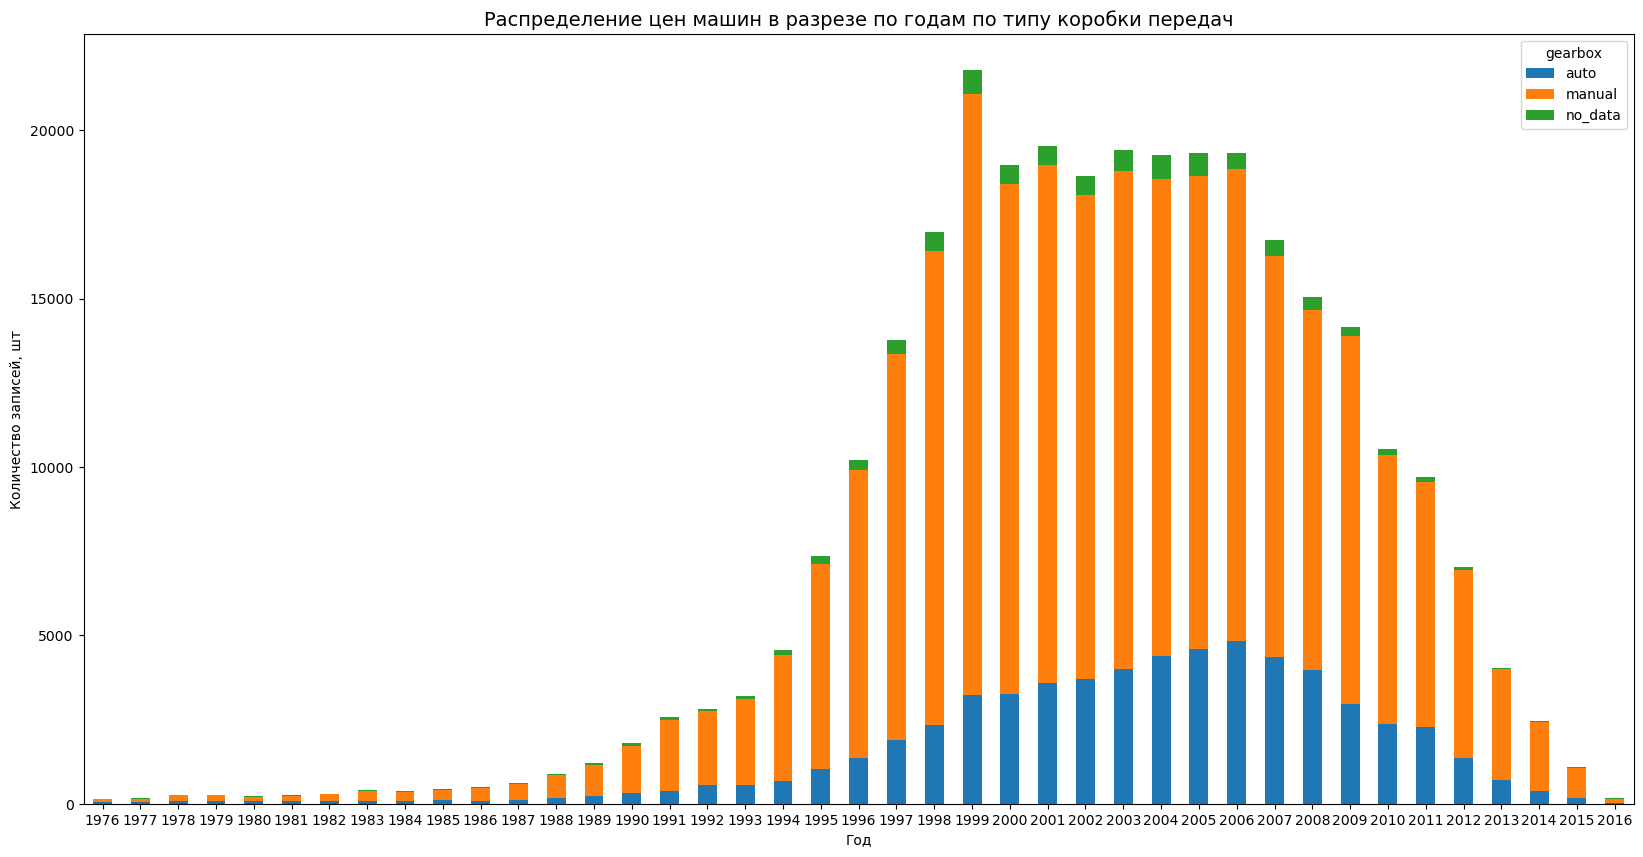

Доля пропущенных значений 2.87%:
Количество пропущенных значений: 8784


In [34]:
intro_categ(df0,'gearbox', "по типу коробки передач")

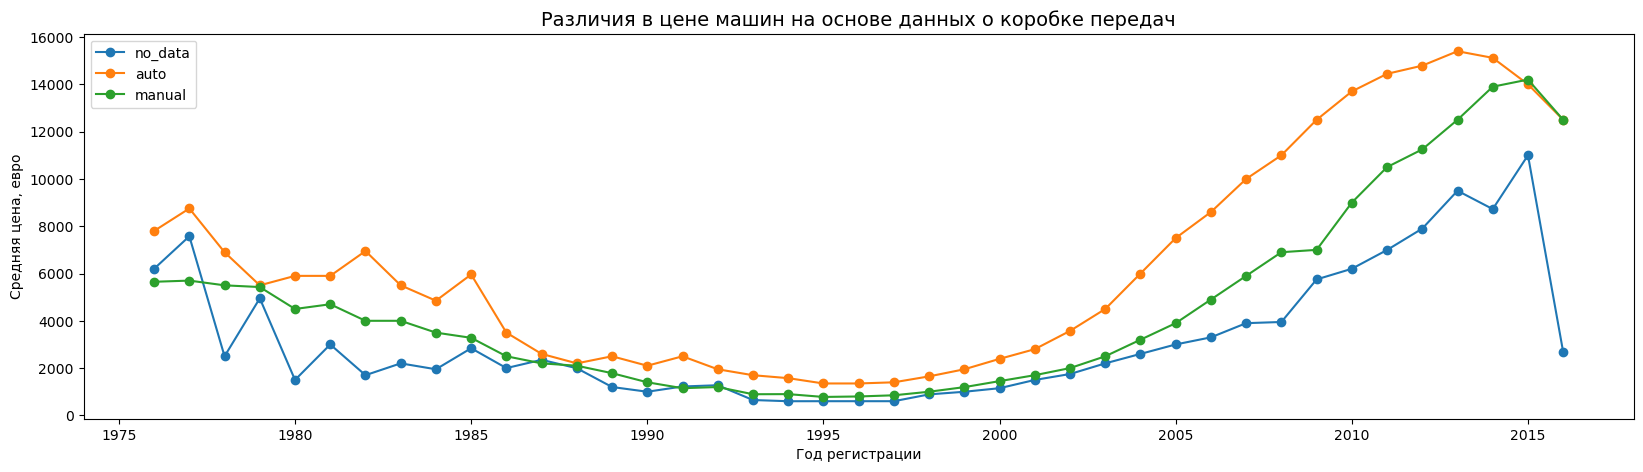

In [35]:
temp = pd.DataFrame(columns = ['no_data', 'auto', 'manual'])
temp['no_data'] = df0.query('gearbox == "no_data"').groupby('registrationyear')['price'].median()
temp['auto'] = df0.query('gearbox == "auto"').groupby('registrationyear')['price'].median()
temp['manual'] = df0.query('gearbox == "manual"').groupby('registrationyear')['price'].median()

g=temp.plot(style='o-', figsize = (20,5))

g.axes.set_title("Различия в цене машин на основе данных о коробке передач", fontsize=14)
g.set_xlabel("Год регистрации", fontsize=10)
g.set_ylabel("Средняя цена, евро", fontsize=10)
plt.show()

По данным по типу коробки передач аналогичная картина: общий тренд соответствует, но цена 2016 года резко "проседает" по сравнению с двумя остальными типами, а также наблюдаются скачки в цене на машины 1975-1985 гг.

Считаем необходимым удалить их, т.к. восстановление категории невозможно, а данные по цене могут быть искажены при отнесении их к тому или иному типу коробки передач.

In [36]:
df0 = df0.query('gearbox != "no_data"')
print("Сокращение датасета на текущем этапе от начального значения {0:.2%}".format(1-len(df0)/len(df)))

Сокращение датасета на текущем этапе от начального значения 16.00%


Проверим столбец с моделями автомобилей.

Уникальные значения: [nan 'grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other' 'civic'
 'transporter' 'punto' 'e_klasse' 'kadett' 'one' 'fortwo' 'clio' '1er'
 'b_klasse' 'signum' 'astra' 'a8' 'jetta' 'polo' 'fiesta' 'c_klasse'
 'micra' 'vito' 'sprinter' '156' 'escort' 'forester' 'xc_reihe' 'scenic'
 'a4' 'a1' 'combo' 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' 'corsa'
 '80' '147' 'z_reihe' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran'
 'getz' 'insignia' 'ka' 'megane' 'a3' 'lupo' 'r19' 'mondeo' 'cordoba'
 'colt' 'impreza' 'vectra' 'berlingo' 'tiguan' 'sharan' '6_reihe' 'c4'
 'panda' 'up' 'i_reihe' 'ceed' 'kangoo' '5_reihe' 'yeti' 'octavia'
 'zafira' 'mii' 'rx_reihe' '6er' 'fox' 'matiz' 'beetle' 'rio' 'touareg'
 'logan' 'caddy' 'spider' 'cuore' 's_max' 'modus' 'a2' 'galaxy' 'c3'
 'viano' 's_klasse' '1_reihe' 'avensis' 'roomster' 'sl' 'santa' 'cooper'
 'leon' '4_reihe' 'a5' 'sportage' 'laguna' 'ptcruiser' 'clk

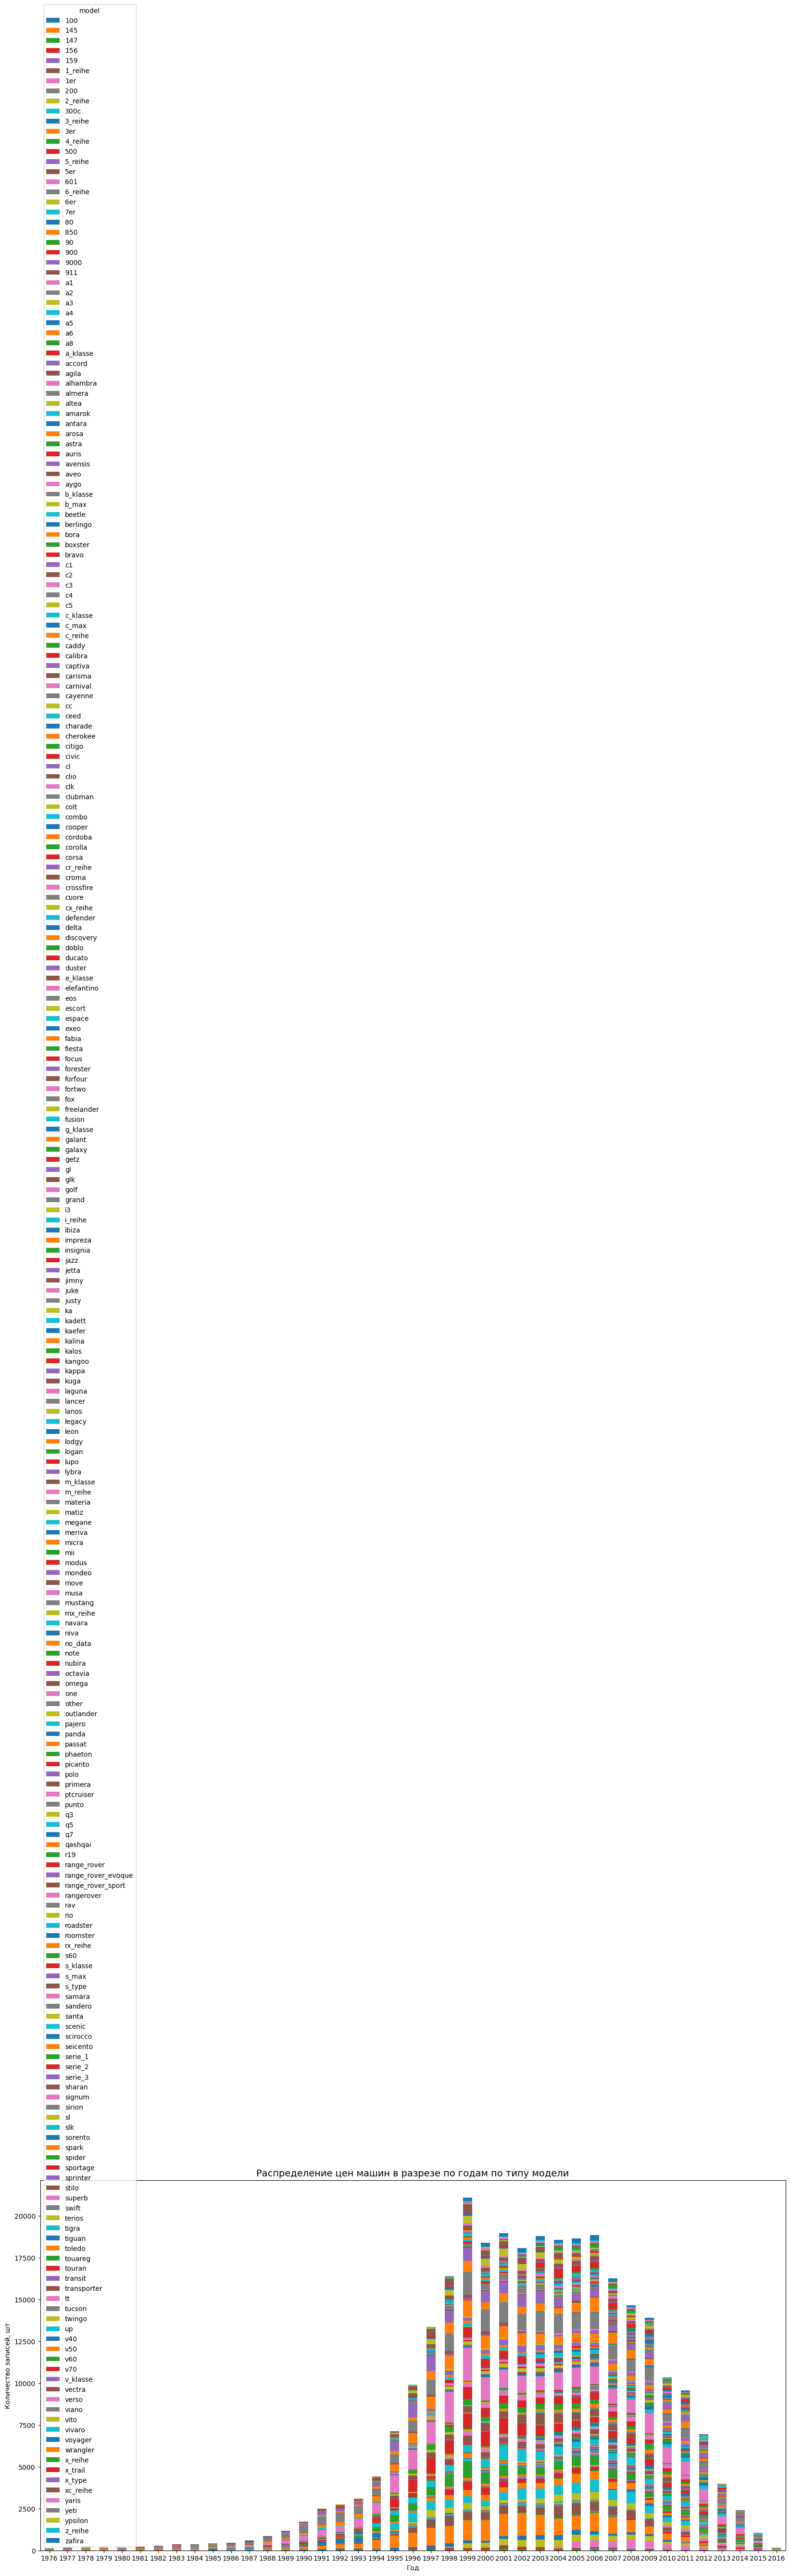

Доля пропущенных значений 3.52%:
Количество пропущенных значений: 10484


In [37]:
intro_categ(df0,'model', "по типу модели")

Т.к. моделей очень много, при изучении цены на автомобили будет целесообразно сгруппировать их в три основные группы:автомобили без данных о модели, автомобили с группой "другие" и все остальные модели.

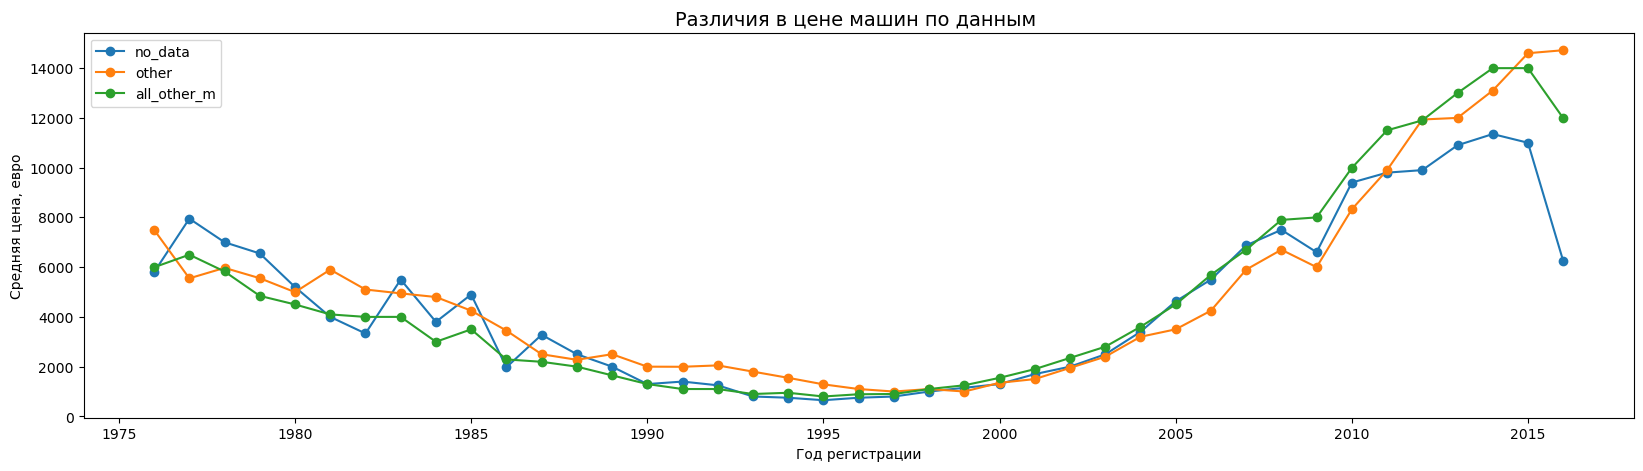

In [38]:
temp = pd.DataFrame(columns = ['no_data', 'other', 'all_other_m'])
temp['no_data'] = df0.query('model == "no_data"').groupby('registrationyear')['price'].median()
temp['other'] = df0.query('model == "other"').groupby('registrationyear')['price'].median()
temp['all_other_m'] = df0.query(
    'model != "no_data" & model != "other"'
).groupby('registrationyear')['price'].median()

g=temp.plot(style='o-', figsize = (20,5))

g.axes.set_title("Различия в цене машин по данным ", fontsize=14)
g.set_xlabel("Год регистрации", fontsize=10)
g.set_ylabel("Средняя цена, евро", fontsize=10)
plt.show()

В целом данные повторяют точь-в точь как общий тренд, так и тренд собирательно называемый *"другой" (other)*, за исключением 2016 года, когда тренд категории "другие" восходящий, в котличие от других категорий. Считаем возможным в данном случае сохранить данные и объединить с категорией "другие".

In [39]:
df0['model'] = df0['model'].replace('no_data', 'other')

Обработаем последний тип - fueltype: заполним "заглушкой" в виде "no_data" и проверим аналогичным образом.

Уникальные значения: ['gasoline' 'petrol' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


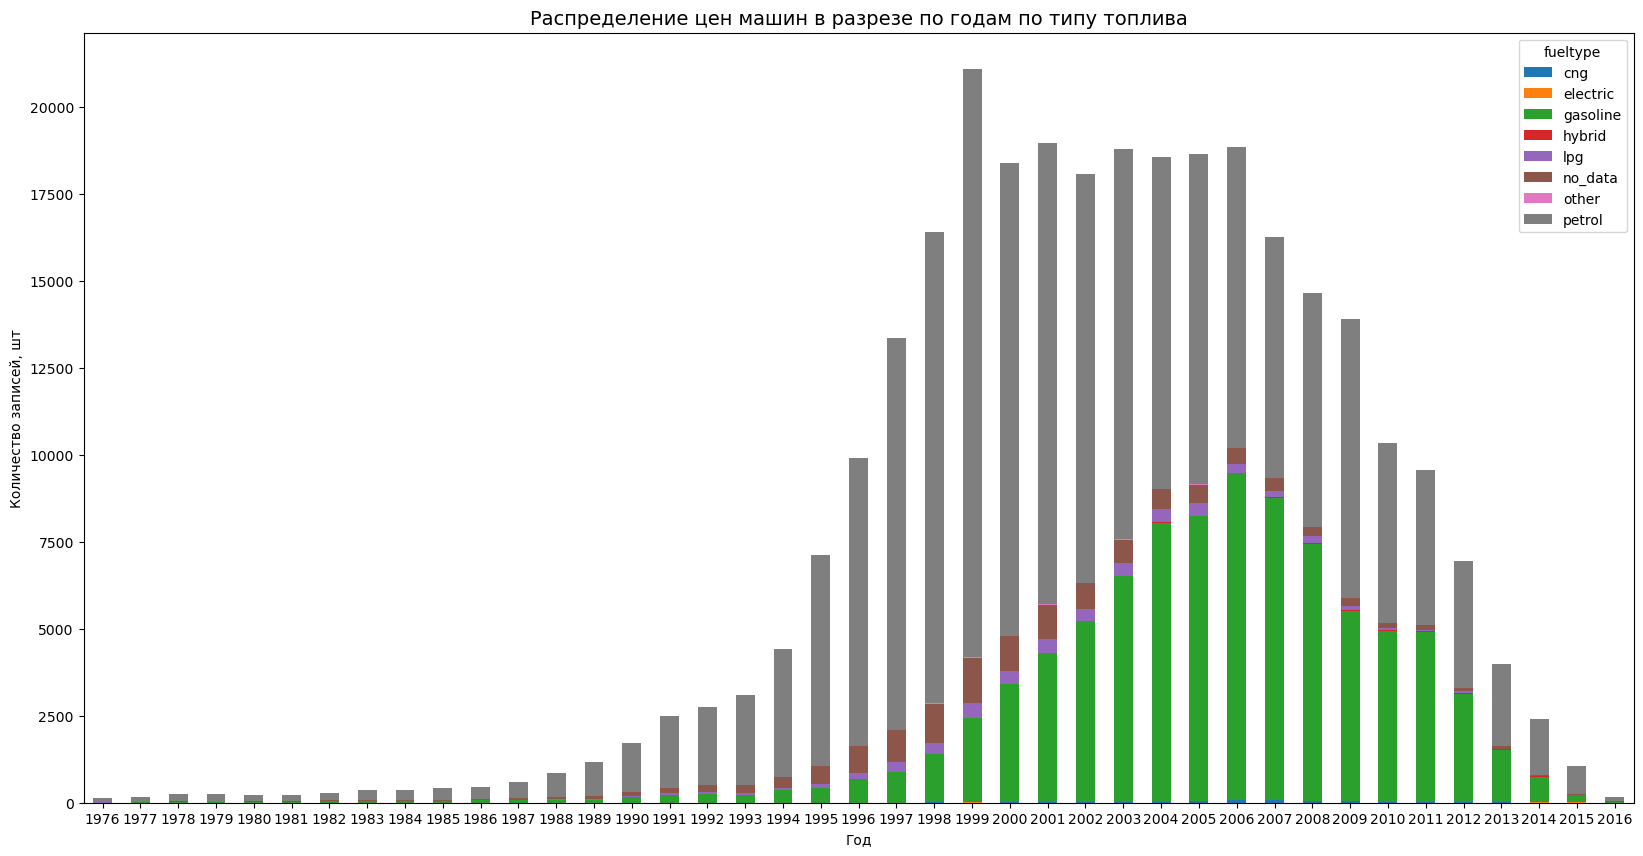

Доля пропущенных значений 4.15%:
Количество пропущенных значений: 12359


In [40]:
intro_categ(df0,'fueltype', "по типу топлива")

Как видно из графика выше, ожидаемо машины в основном используют либо бензин (petrol, gasoline). Попутно мы выявили нюанс в том, что в разных марках один и тот же и топлива называется по-разному (gasoline - американская версия названия, petrol - британская). Фактически абсолютное большиство машин представлено машинами с бензиновым двигателем. По данному графику скорее можно понять распределение моделей по их страновой принадлежности: большая часть неевропейских марок представлена машинами 1997-2013 гг выпуска.

Прочими видами, расшифрованными в данном графике, являются два типа газовых двигателей (cng и ipg), электрические и гибридные автомобили, но их доля очень мала.

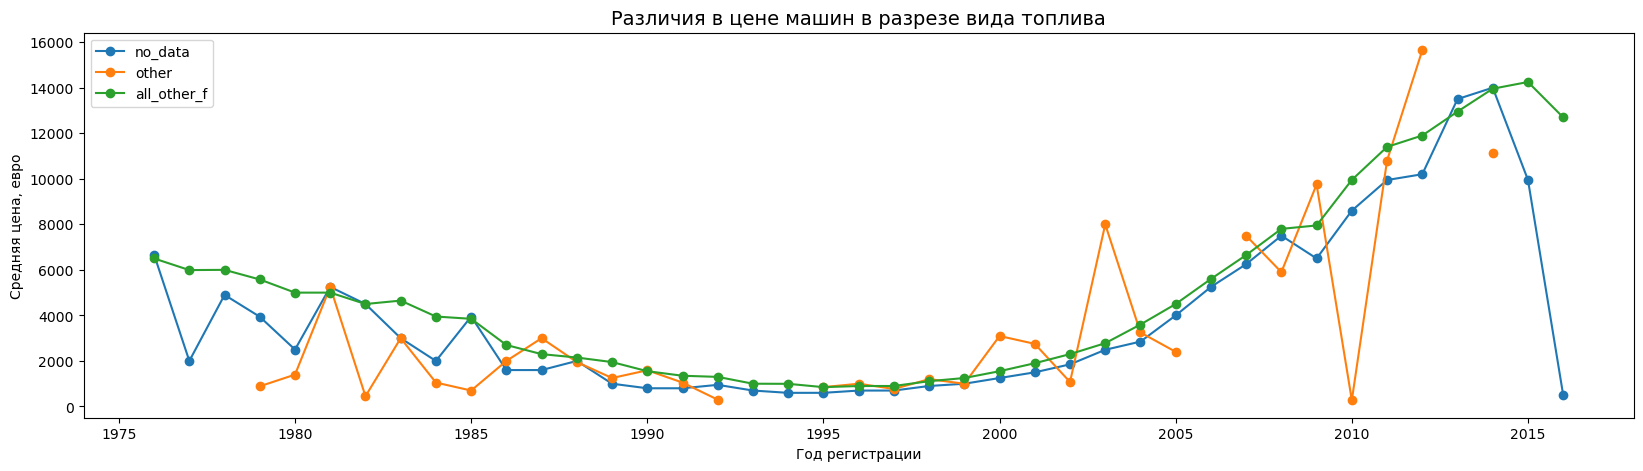

Количество машин без данных о двигателе: 12359
Количество машин на известных типах двигателей: 285224
Количество машин с данными о типе двигателя 'other': 94


In [41]:
temp = pd.DataFrame(columns = ['no_data', 'other', 'all_other_f'])
temp['no_data'] = df0.query('fueltype == "no_data"').groupby('registrationyear')['price'].median()
temp['other'] = df0.query('fueltype == "other"').groupby('registrationyear')['price'].median()
temp['all_other_f'] = df0.query(
    'fueltype != "no_data" & fueltype != "other"').groupby('registrationyear')['price'].median()

g=temp.plot(style='o-', figsize = (20,5))

g.axes.set_title("Различия в цене машин в разрезе вида топлива", fontsize=14)
g.set_xlabel("Год регистрации", fontsize=10)
g.set_ylabel("Средняя цена, евро", fontsize=10)
plt.show()
print ("Количество машин без данных о двигателе:", df0.query(
    'fueltype == "no_data"')['price'].count())

print ("Количество машин на известных типах двигателей:", df0.query(
    'fueltype != "no_data" & fueltype != "other"')['price'].count())

print ("Количество машин с данными о типе двигателя 'other':", df0.query(
    'fueltype == "other"')['price'].count())

Как видно из графика выше, тренд по цене по машинам без данных о двигателе аналогичен общему, с некоторыми колебаниями, объясняемыми меньшей выборкой по сранвению с основным трендом. Группа "other" еще более немногочисленна, поэтому по ней наблюдаются как резкие "пики", так и резкие "провалы". Объединим группы машин без данных и "other" и посмотрим на то, как будет выглядеть общий тренд.

In [42]:
df0['fueltype'] = df0['fueltype'].replace('no_data','other')
df0['fueltype'].unique()

array(['gasoline', 'petrol', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

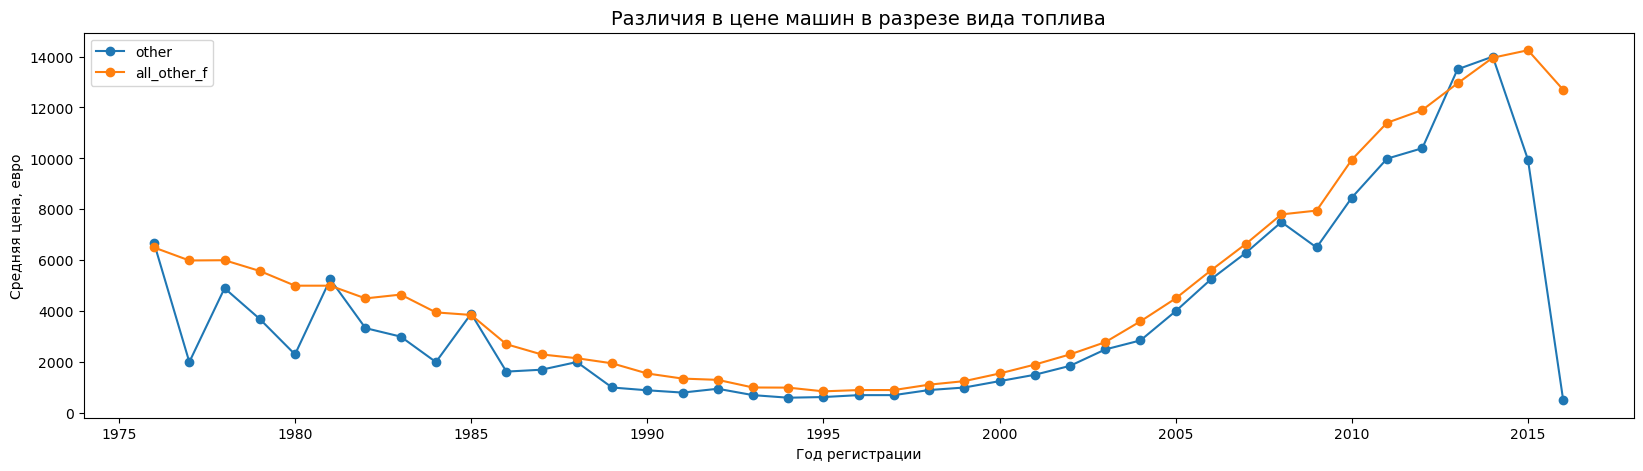

In [43]:
temp = pd.DataFrame(columns = ['other', 'all_other_f'])
temp['other'] = df0.query('fueltype == "other"').groupby('registrationyear')['price'].median()
temp['all_other_f'] = df0.query('fueltype != "other"').groupby('registrationyear')['price'].median()

g=temp.plot(style='o-', figsize = (20,5))

g.axes.set_title("Различия в цене машин в разрезе вида топлива", fontsize=14)
g.set_xlabel("Год регистрации", fontsize=10)
g.set_ylabel("Средняя цена, евро", fontsize=10)
plt.show()

Ожидаемо график с прочими видами топлива сгладился, тренд в целом повторяет основной тренд автомобилей, оставим данные в таком виде.

In [44]:
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
price,297677.0,4812.568361,4588.439189,100.0,1300.0,3100.0,6950.0,20000.0
registrationyear,297677.0,2002.614733,5.780210,1976.0,1999.0,2003.0,2007.0,2016.0
power,297677.0,117.459404,183.146537,0.0,75.0,109.0,147.0,20000.0
kilometer,297677.0,128586.689600,36586.557515,5000.0,125000.0,150000.0,150000.0,150000.0
postalcode,297677.0,51009.756565,25769.624280,1067.0,30823.0,49828.0,71665.0,99998.0
year_creation,297677.0,2015.999923,0.008790,2015.0,2016.0,2016.0,2016.0,2016.0


Пропуски обработаны, обратимся к оставшимся без внимания столбцам для проверки их данных на адекватность и общего понимания датасета. Это Power, Kilometer, Brand, Repaired, PostalCode.

Пойдем в порядке их нахождения в таблице, первым проверим столбец с мощностью двигателя. В нем имеются нулевые или околонулевые значения, что не является нормальным для автомобиля.

In [45]:
df0['power'].isna().sum()

0

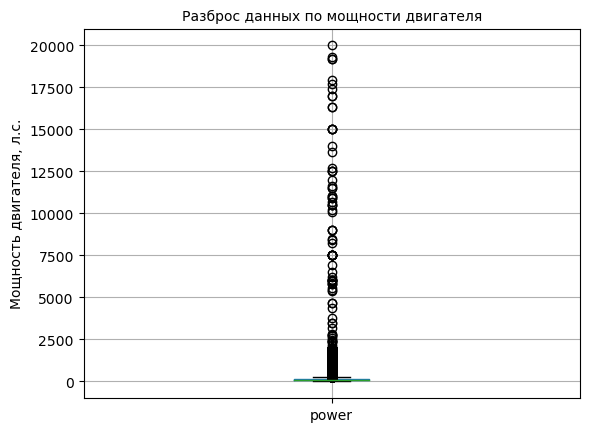

In [46]:
df0.boxplot('power')
plt.title("Разброс данных по мощности двигателя", fontsize=10)
plt.ylabel("Мощность двигателя, л.с.", fontsize=10)
plt.show()

Судя по имеющимся данным, в наличии имеются не только машины, но и самолеты (например, мощность среднего Boeing-737 с его 190 посадочными местами с двумя двигателями по 12 тонн силы каждый - около 25 000 лошадиных сил). Взглянем на основную массу наблюдений поближе.

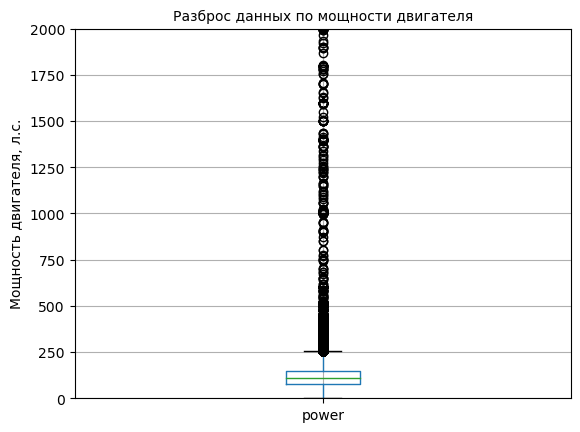

In [47]:
df0.boxplot('power')
plt.ylim(0,2000)
plt.title("Разброс данных по мощности двигателя", fontsize=10)
plt.ylabel("Мощность двигателя, л.с.", fontsize=10)
plt.show()

Выбросов в большую сторону очень много, при этом медиана лежит на уровне 109 л.с. Можно предположить сразу 2 гипотезы:
 - имеет место неправильная выгрузка (лишние нули);
 - у части автомобилей данные на самом деле не в лошадиных силах, а в ваттах (при этом 1 л.с. - это ок.735 ватт в европейских странах и ок.745 в США и Великобритании).
 
Проверим, сколько таких записей всего и какую долю они составляют от общего количества оставшихся записей. За точку "отсечения" возьмем два стандартных отклонения.

In [48]:
print("Всего записей с мощностью свыше 250 л.с.",df0.query('power>250')['model'].count())
print("Доля записей с мощностью свыше 250 л.с. в общем объеме:{0:.2%}".format(
      df0.query('power>250')['model'].count()/len(df0['power'])))

Всего записей с мощностью свыше 250 л.с. 6671
Доля записей с мощностью свыше 250 л.с. в общем объеме:2.24%


Процент таких записей относительно невелик, примем первое предположение об ошибках с количеством нулей за базу.

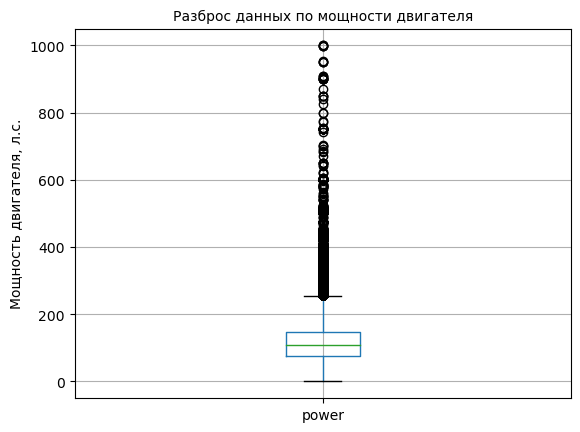

In [49]:
df0.loc[df0['power'] >1000,'power'] = df0.loc[df0['power'] >1000,'power']/10
#проведем сокращение дважды, т.к. часть записей могла быть с двумя лишними нулями
df0.loc[df0['power'] >1000,'power'] = df0.loc[df0['power'] >1000,'power']/10

df0.boxplot('power')
plt.title("Разброс данных по мощности двигателя", fontsize=10)
plt.ylabel("Мощность двигателя, л.с.", fontsize=10)
plt.show()

In [50]:
df0.query('power>250').groupby('vehicletype')['power'].median()

vehicletype
bus            272.0
convertible    300.0
coupe          300.0
other          306.0
sedan          286.0
small          557.5
suv            306.0
wagon          286.0
Name: power, dtype: float64

In [51]:
df0.query('vehicletype == "small"').groupby('model')['power'].median().sort_values(ascending=False)

model
s_type      600.0
rx_reihe    231.0
tt          200.0
scirocco    200.0
clk         180.0
            ...  
a4            0.0
antara        0.0
octavia       0.0
toledo        0.0
calibra       0.0
Name: power, Length: 160, dtype: float64

Уже по типу кузова можно было сказать, что имеется ошибка в данных (малые машины с необычно мощными двигателями). Теперь ошибка стала более явной: например, Lancia Ypsilon - это малый автомобиль, комплектовавшийся, как правило, двигателями в 80-105 л.с., а s_type даже в премиальной версии не превосходил 400 л.с.

Теперь проверим нижнюю границу данных.

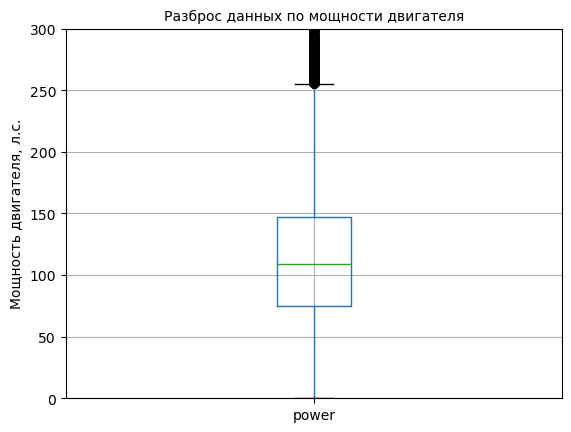

In [52]:
df0.boxplot('power')
plt.ylim(0,300)
plt.title("Разброс данных по мощности двигателя", fontsize=10)
plt.ylabel("Мощность двигателя, л.с.", fontsize=10)
plt.show()

In [53]:
df0.query('power<50').groupby('model')['power'].median()

model
100         0.0
145         0.0
147         0.0
156         0.0
159         0.0
           ... 
xc_reihe    0.0
yaris       0.0
ypsilon     0.0
z_reihe     0.0
zafira      0.0
Name: power, Length: 236, dtype: float64

In [54]:
df0.query('power<50')['power'].count()

22607

Имеется также небольшое число нулевых значений, явно ошибочного характера, достаточно большой массив. Заполним и нулевые, и оставшиеся "экстремальные" значения медианным значением по такой же группе машин (бренд, модель, коробка передач), т.к. как правило машины комплектуются примерно идентичными двигателями во всей линейке с минимальными отклонениями.
Для упрощения кода приравняем такие значения к nan, а затем заполним их необходимыми значениями

In [55]:
#сначала обработаем околонулевые значения
df0['power'] = df0['power'].where(df0['power'] >= 50, np.nan)
#заполним данные
df0.power.fillna(
    df0.groupby(['model','brand','gearbox'])['power'].transform('median'), inplace=True)
df0['power'].isna().sum()

2

Изучим оставшиеся пустыми значения.

In [56]:
a = df0.loc[(df0['power'].isna()==True),['brand','model','gearbox']]
a.pivot_table(
    index = 'brand',
    columns = 'gearbox',
    values = 'model',
    aggfunc='count')

gearbox,manual
brand,
land_rover,1
rover,1


In [57]:
df0[df0['power'].isna() == True]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,datecreated,postalcode,lastseen,year_creation
108768,2016-03-17 21:42:54,2800,suv,1999,manual,NaN,freelander,150000,gasoline,rover,no_data,2016-03-17,17279,2016-03-22 04:16:06,2016
234296,2016-03-30 11:39:08,3800,wagon,1978,manual,NaN,serie_1,30000,gasoline,land_rover,no_data,2016-03-30,49824,2016-03-30 11:39:08,2016


In [58]:
df0[df0['model'] == "serie_1"]['price'].count()

1

В результате у нас вместо нулевого значения л.с. появилось значение NaN, т.к. даннаые машины существуют в одном экземпляре. В первом случае, т.к. мы не знаем реального значения л.с. этой машины, и она существует в 1 экземпляре в датафрейме, удалим его, во втором (в случае с ровером) - приравняем значение в л.с. к аналогичной машине с автоматической коробкой передач

In [59]:
df0 = df0.query('model != "serie_1"')

In [60]:
df0.loc[(df0['model'] == "freelander") & (df0['brand'] == "rover") & (df0['gearbox'] == "manual"), 'power'] = \
df0.loc[(df0['model'] == "freelander") & (df0['brand'] == "rover") & (df0['gearbox'] == "auto"), 'power'].mean()
# без "среднего" функция не сработала.
df0[df0['power'].isna() == True]['price'].count()

0

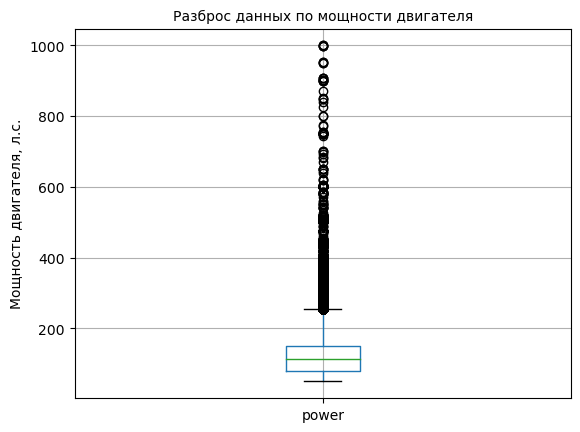

In [61]:
df0.boxplot('power')

plt.title("Разброс данных по мощности двигателя", fontsize=10)
plt.ylabel("Мощность двигателя, л.с.", fontsize=10)
plt.show()

In [62]:
df0.groupby('model')['power'].max().sort_values(ascending=False)

model
other         1000.0
lupo          1000.0
micra          998.0
colt           953.0
ka             952.0
               ...  
mii             75.0
samara          75.0
serie_3         69.0
elefantino      60.0
601             50.0
Name: power, Length: 249, dtype: float64

In [63]:
df0.groupby('model')['power'].median().sort_values(ascending=False)

model
m_reihe    343.0
cayenne    340.0
6er        333.0
cl         306.0
911        300.0
           ...  
matiz       53.0
601         50.0
kaefer      50.0
lupo        50.0
arosa       50.0
Name: power, Length: 249, dtype: float64

Если проверить и сопоставить значения максимальной мощности мотора моделей из "выбросов" свыше 300 л.с., то становится явно видно, что автомобили такого типа не могут обладать заявленной мощностью (например, Ниссан Микра). Приведем значения в датафрейме к медианному по ранее использованному критерию отбора (медиана по машинам аналогичного бренда, модели и типа коробки передач). В качестве нижней границы поставим 500 л.с., что в 1.5 раза больше, чем самое большое медианное значение.

In [64]:
df0['power'] = df0['power'].where(df0['power'] <= 500, np.nan)
df0.power.fillna(
    df0.groupby(['model','brand','gearbox'])['power'].transform('median'), inplace=True)
df0['power'].isna().sum()

0

In [65]:
df0.groupby('model')['power'].max().sort_values(ascending=False)

model
s_klasse      500.0
corsa         500.0
other         500.0
golf          500.0
sl            500.0
              ...  
citigo         75.0
seicento       74.0
serie_3        69.0
elefantino     60.0
601            50.0
Name: power, Length: 249, dtype: float64

Таким образом мы обошлись без дальнейшего сокращения выборки. Есть некоторая вероятность того, что таким образом мы упустили важные выбросы, однако, как показал предварительный анализ, максимальные значения были отмечены на машинах-малолитражках, что в принципе противоречит их конструкции. Следовательно, наша замена данных на медианные дала более корректную картину.


Изучим столбец "kilometer" - пробег.

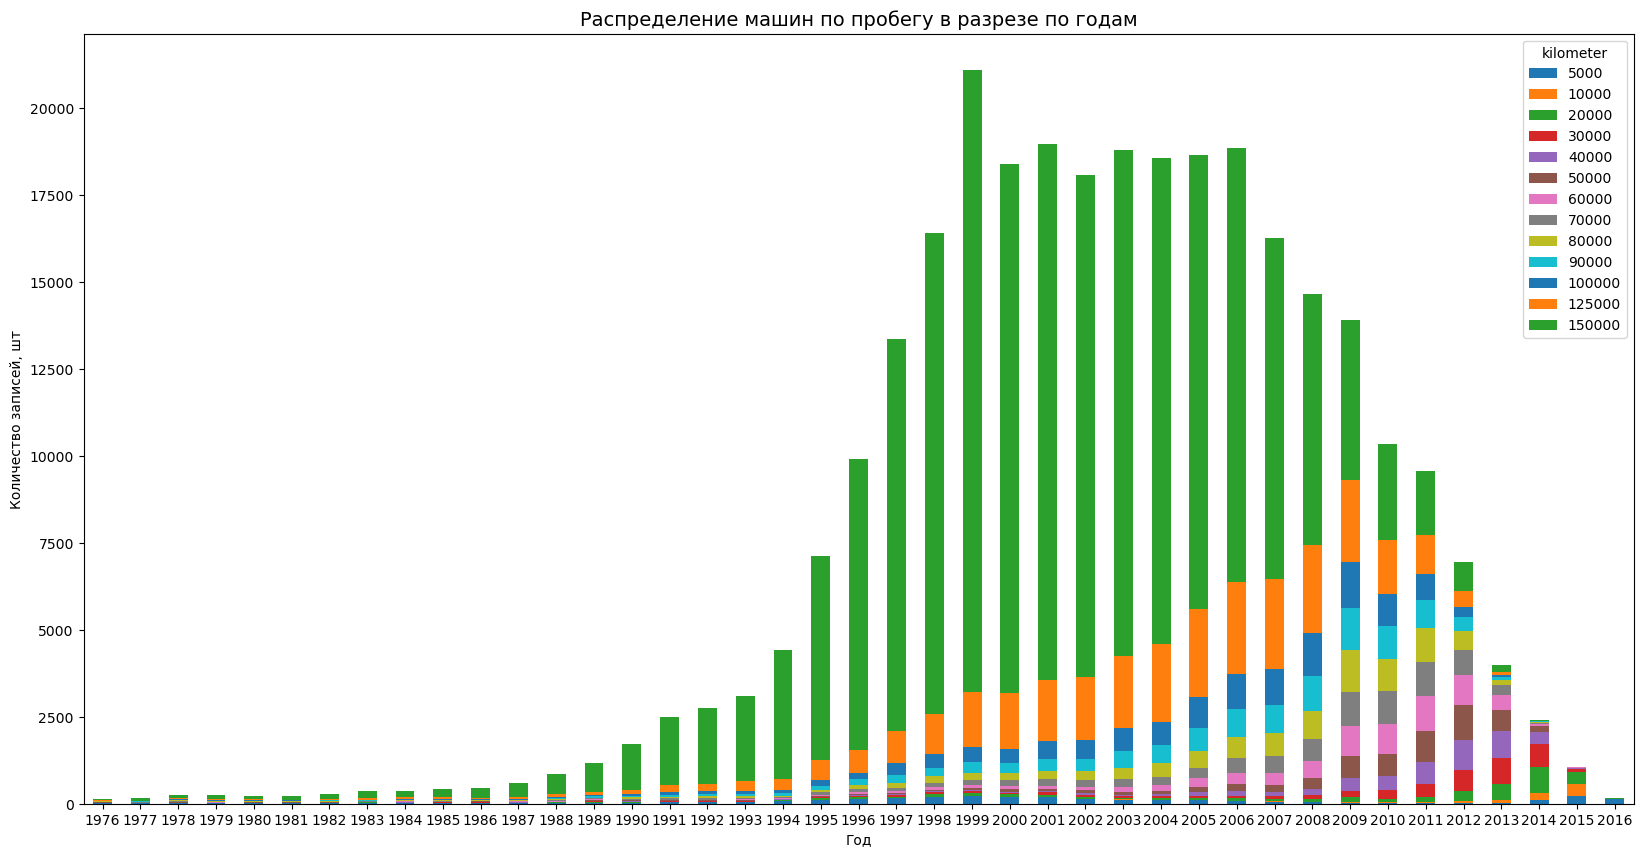

In [66]:
g = df0.pivot_table(
    index = 'registrationyear',
    columns = 'kilometer',
    values = 'price',
    aggfunc='count').plot.bar(rot=0, grid=False,figsize = (20,10),stacked = True)
g.axes.set_title("Распределение машин по пробегу в разрезе по годам", fontsize=14)
g.set_xlabel("Год", fontsize=10)
g.set_ylabel("Количество записей, шт", fontsize=10)
plt.show()

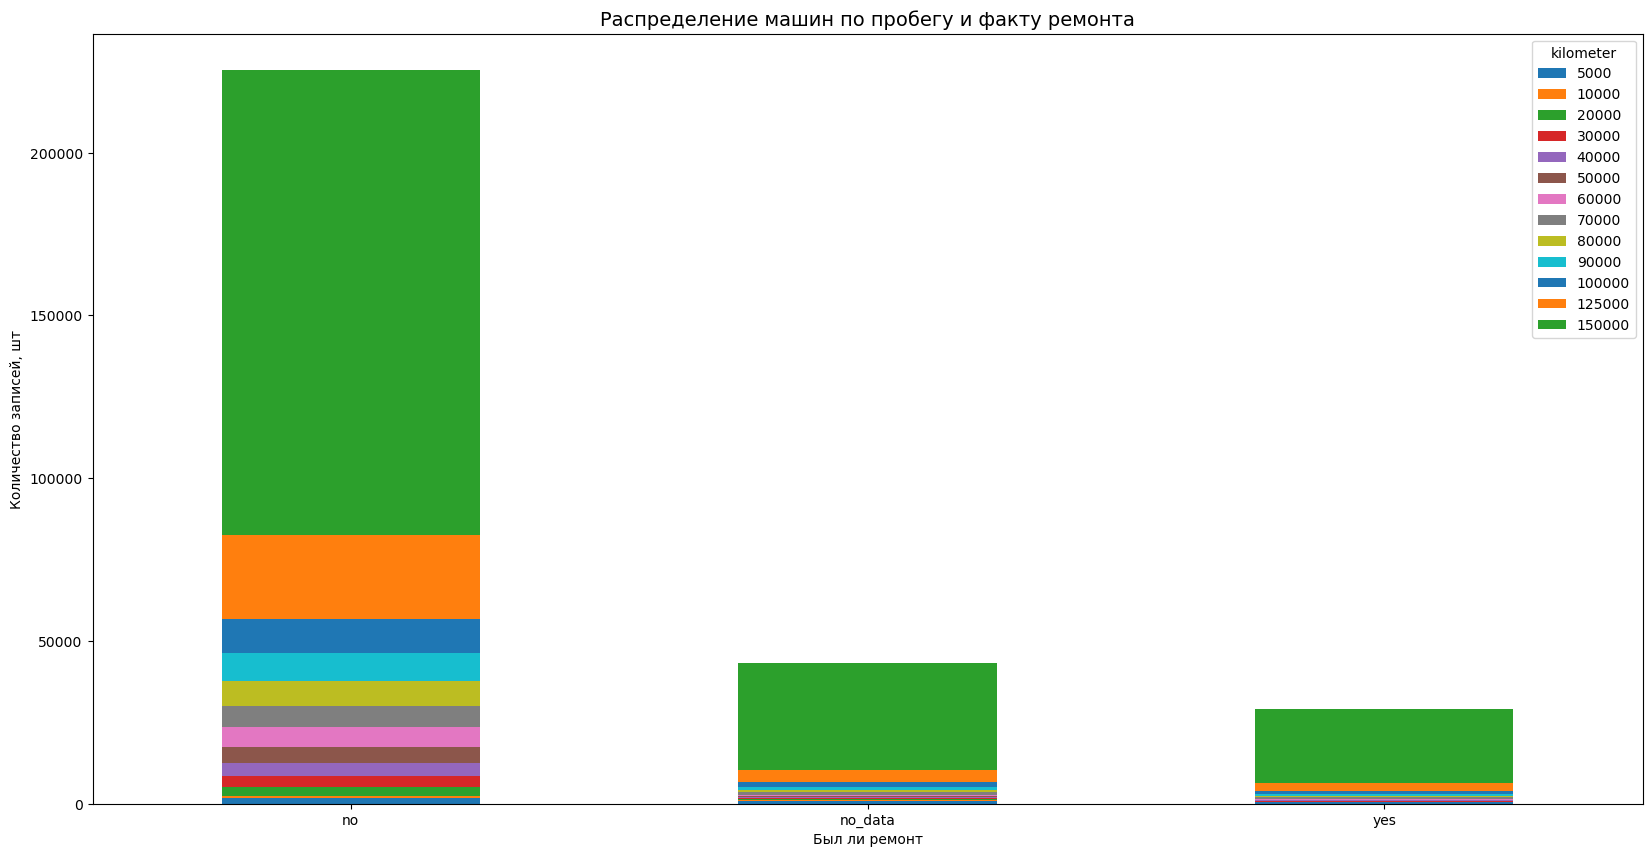

In [67]:
g = df0.pivot_table(
    index = 'repaired',
    columns = 'kilometer',
    values = 'price',
    aggfunc='count').plot.bar(rot=0, grid=False,figsize = (20,10),stacked = True)
g.axes.set_title("Распределение машин по пробегу и факту ремонта", fontsize=14)
g.set_xlabel("Был ли ремонт", fontsize=10)
g.set_ylabel("Количество записей, шт", fontsize=10)
plt.show()

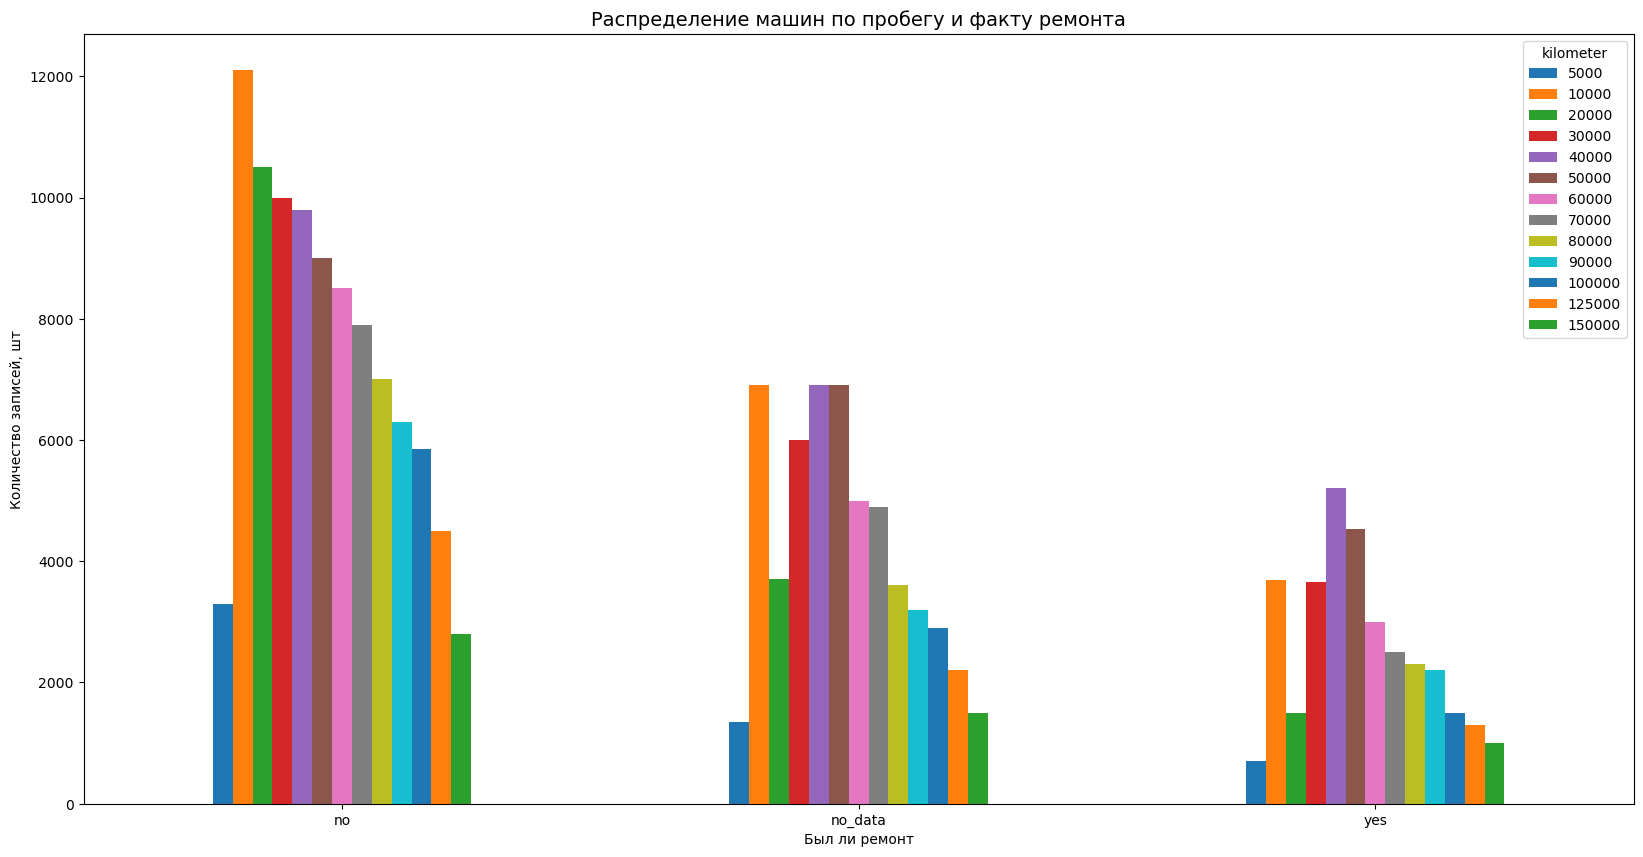

In [68]:
g = df0.pivot_table(
    index = 'repaired',
    columns = 'kilometer',
    values = 'price',
    aggfunc='median').plot.bar(rot=0, grid=False,figsize = (20,10),stacked = False)
g.axes.set_title("Распределение машин по пробегу и факту ремонта", fontsize=14)
g.set_xlabel("Был ли ремонт", fontsize=10)
g.set_ylabel("Количество записей, шт", fontsize=10)
plt.show()

Интересно, что большое количество машин, будучи достаточно изношенными в категории пробега (125 000 км и выше), согласно данным таблицы, никогда не проходили серьезных починок в автомастерской. Цена на такие машины, соответственно, выше. Примем пока указанные данные, также оставим заглушку "no_data" в столбце ремонта за неимением других косвенных данных, позволяющих восстановить картину.

Проверим данные по коду региона, имеется ли какая-то зависимость между ним и пробегом и/или ценой.

In [69]:
df0['postalcode'].isna().sum()

0

Пропусков в данном столбце нет, проверим корреляции.

<Figure size 2000x1000 with 0 Axes>

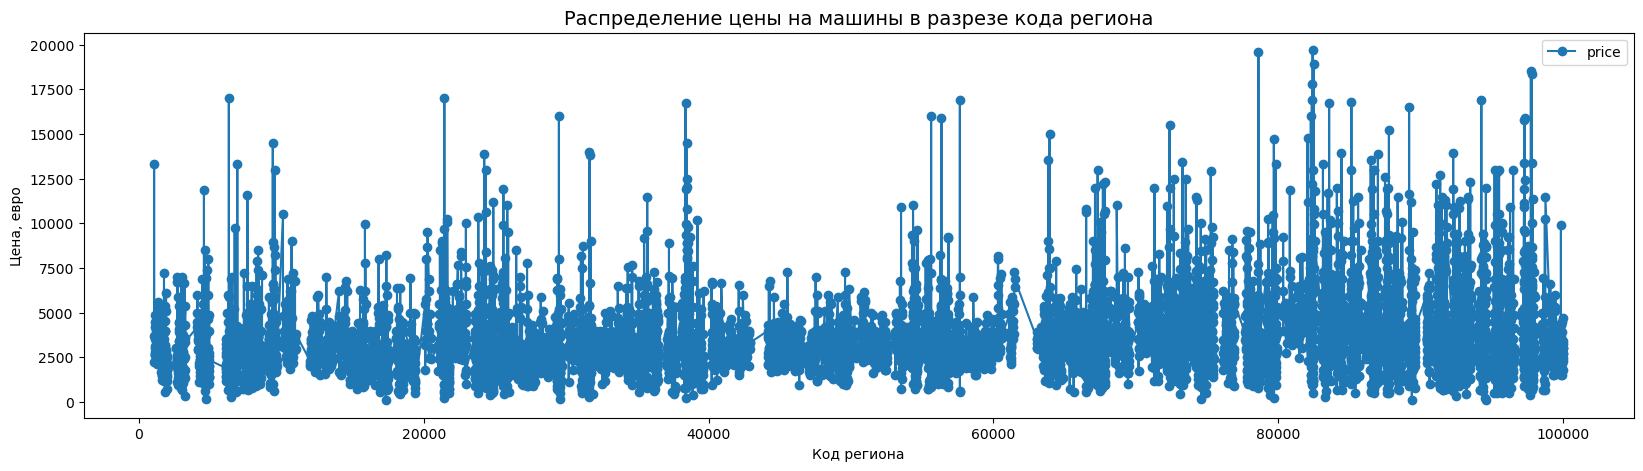

Коэффициент корреляции между регионом и ценой: 0.06876603854317884


In [70]:
plt.figure(figsize=[20,10])
g = df0.pivot_table(
    index = 'postalcode',
    values = 'price',
    aggfunc='median').plot(style='o-', figsize = (20,5))
g.set_title("Распределение цены на машины в разрезе кода региона", fontsize=14)
g.set_xlabel("Код региона", fontsize=10)
g.set_ylabel("Цена, евро", fontsize=10)
plt.show()
print('Коэффициент корреляции между регионом и ценой:',df0['postalcode'].corr(df0['price']))

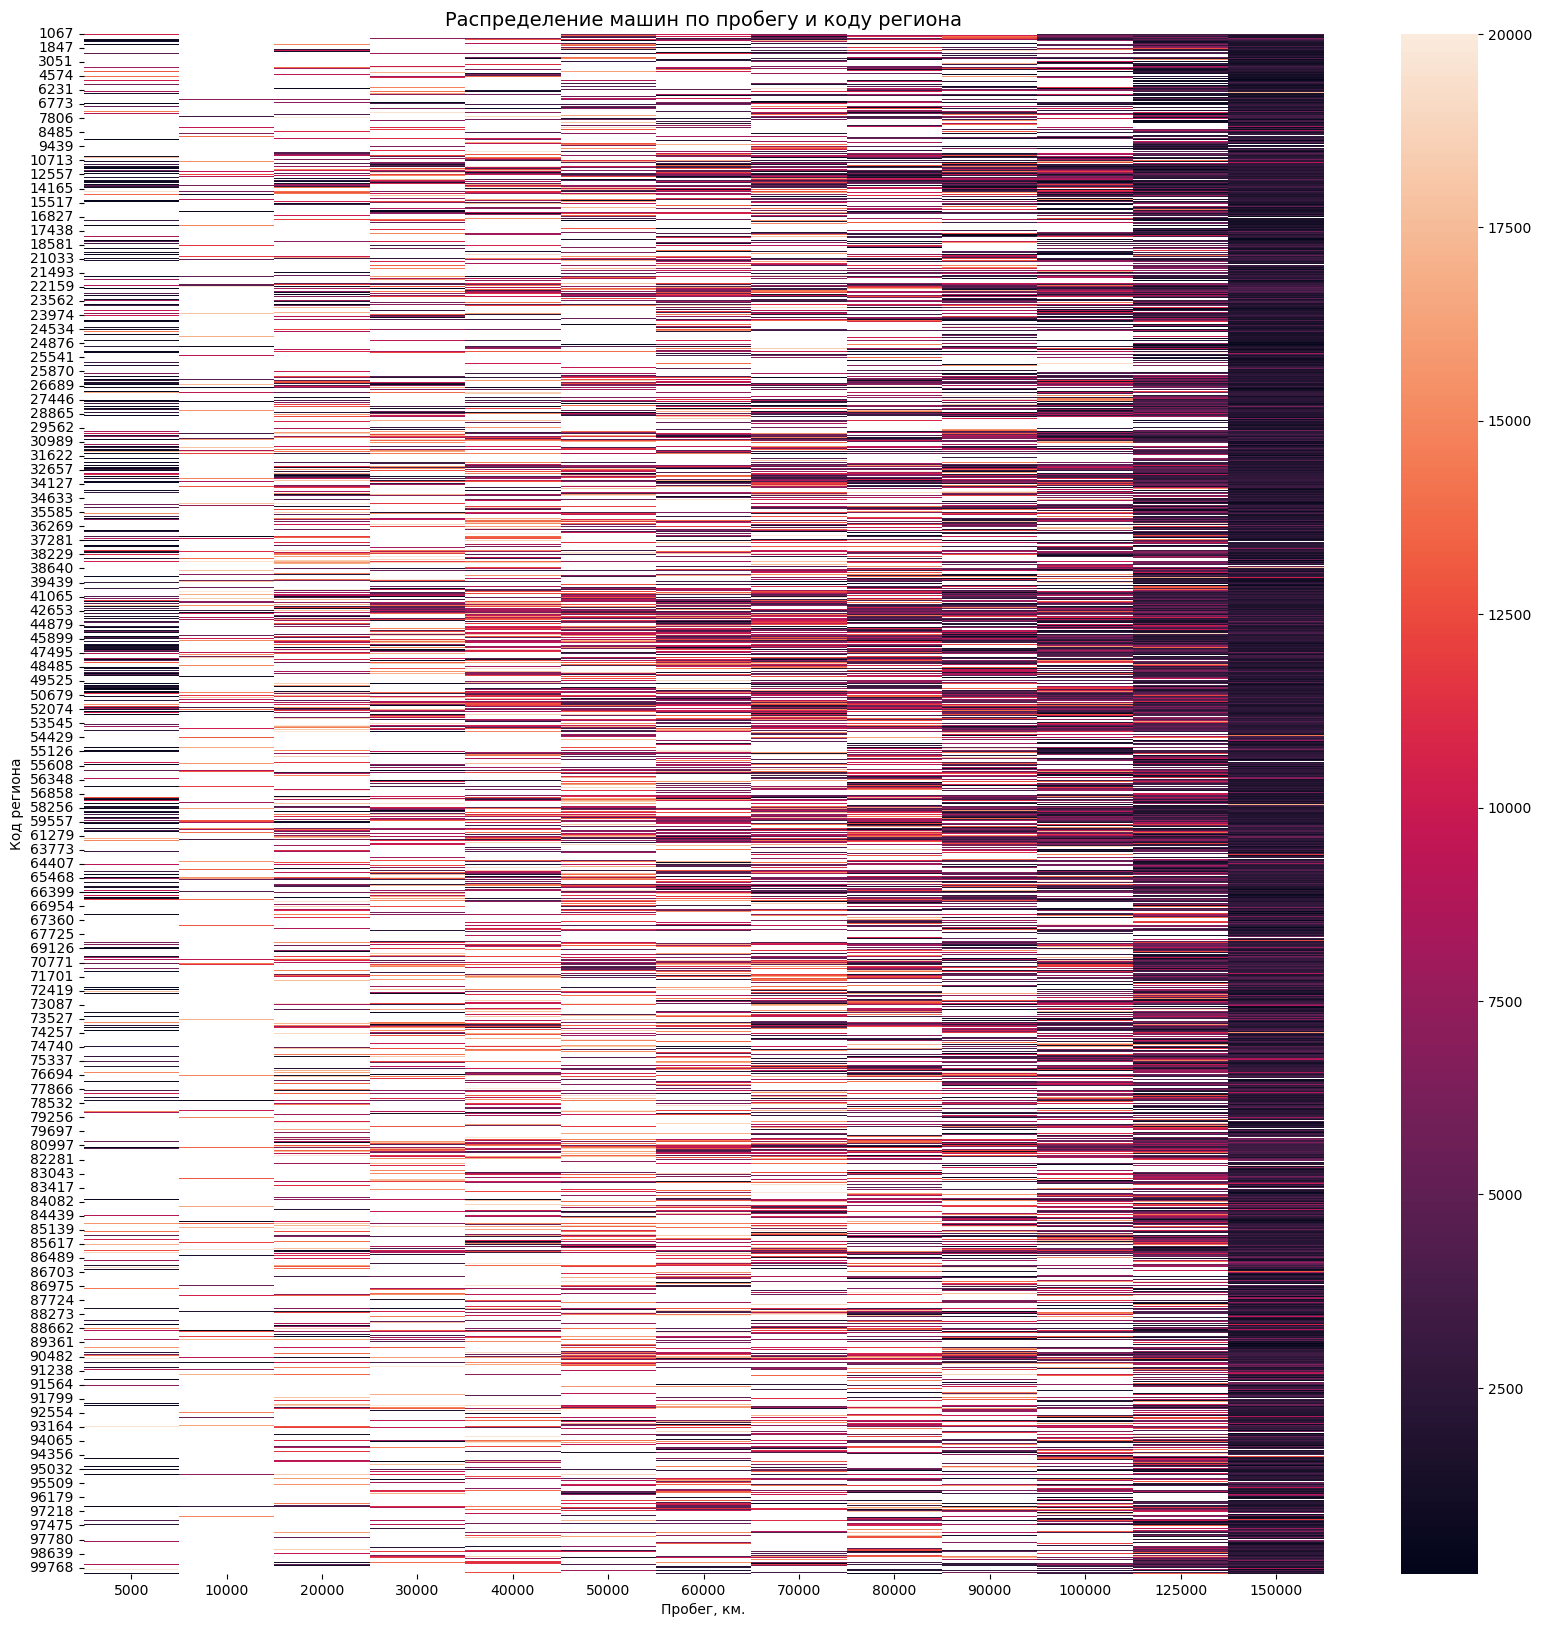

In [71]:
plt.figure(figsize=[20,20])
g = sns.heatmap(df0.pivot_table(
    index = 'postalcode',
    columns = 'kilometer',
    values = 'price',
    aggfunc='median')
               )
g.set_title("Распределение машин по пробегу и коду региона", fontsize=14)
g.set_xlabel("Пробег, км.", fontsize=10)
g.set_ylabel("Код региона", fontsize=10)
plt.show()

На основании указанных выше графиков можно сделать слеюущие выводы:
1. Цена на машины не зависит от региона, коэффициент корреляции между ценой и кодом региона всего 0,06;
2. Ожидаемо машины с б**о**льшим пробегом стоят дешевле;
3. На тепловой карте можно все же найти 4 центра "дешевых" машин, т.е. есть все же регионы, где цена на автомобили может быть ниже, чем в соседних регионах. Скорее всего, это связано с особенностями продаваемых моделей.

С высокой степенью вероятности можно сказать, что все почтовые индексы относятся к Германии.\
Регионы, которые можено выделить с точки зрения цены, это:
1. Берлин (10787, 12769)
2. Брандебург (14476)
3. Саксония (39124)
3. Северный Рейн-Вестфалия (40472,45479, 48159, 41844, 44379, 46569, 59348)
3. Нижняя Саксония (49205, 49838)

Суммируя вышесказанное, наибольшая концентрация подержанных недорогих машин, причем с пробегом менее 150 000 км достигается в регионе Северный Рейн-Вестфалия.\
Сохраним эти данные в составе датафрейма, используем их для обучения моделей.

Проверим итог: нет ли у нас ситуации, когда у нас есть одиночные экземпляры той или иной модели, т.к. для обучения модели необходимо разбивать выборку, а 1 экземпляр той или иной записи может попасть только либо в обучающую, либо в тестовую выборки. Нам важно, чтобы разные типы моделей были представлены в обеих выборках, чтобы модель не училась, например, на Фольксваген поло, а предсказывала стоимость Ламборджини.

In [72]:
df0.groupby('model')['price'].count().sort_values()

model
serie_3                   1
range_rover_evoque        2
serie_2                   3
rangerover                3
kalina                    6
                      ...  
corsa                 10315
polo                  10810
3er                   17557
golf                  23855
other                 30944
Name: price, Length: 249, dtype: int64

Как можно видеть из столбца выше, часть данных осталась в 1 экземпляре. Удалим эти два значения.

In [73]:
df0 = df0[(df0['model'] != 'serie_3') & (df0['model'] != 'serie_1')]
df0.groupby('model')['price'].count().sort_values()

model
range_rover_evoque        2
rangerover                3
serie_2                   3
kalina                    6
samara                    7
                      ...  
corsa                 10315
polo                  10810
3er                   17557
golf                  23855
other                 30944
Name: price, Length: 248, dtype: int64

In [74]:
df0.describe().T

,count,mean,std,min,25%,50%,75%,max
price,297675.0,4812.528133,4588.392481,100.0,1300.0,3100.0,6950.0,20000.0
registrationyear,297675.0,2002.614899,5.779877,1976.0,1999.0,2003.0,2007.0,2016.0
power,297675.0,121.344782,52.412959,50.0,80.0,114.0,150.0,500.0
kilometer,297675.0,128587.251197,36586.018233,5000.0,125000.0,150000.0,150000.0,150000.0
postalcode,297675.0,51009.813552,25769.694532,1067.0,30823.0,49828.0,71665.0,99998.0
year_creation,297675.0,2015.999923,0.008790,2015.0,2016.0,2016.0,2016.0,2016.0


In [75]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297675 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datecrawled       297675 non-null  object        
 1   price             297675 non-null  int64         
 2   vehicletype       297675 non-null  object        
 3   registrationyear  297675 non-null  int64         
 4   gearbox           297675 non-null  object        
 5   power             297675 non-null  float64       
 6   model             297675 non-null  object        
 7   kilometer         297675 non-null  int64         
 8   fueltype          297675 non-null  object        
 9   brand             297675 non-null  object        
 10  repaired          297675 non-null  object        
 11  datecreated       297675 non-null  datetime64[ns]
 12  postalcode        297675 non-null  int64         
 13  lastseen          297675 non-null  object        
 14  year

Итак, данные мы подготовили, достаточно большой процент данных пришлось удалить, т.к. он не подлежал восстановлению и при этом содержал значительные искажения. Следующим этапом обучим модели.

## Обучение моделей

### Выделение features и target, кодирование категориальных признаков и масштабирование количественных.

Первым этапом выделим features и target, затем разобьем выборку на тренировочную и валидационную. Удалим из массива столбцы c данными анкеты - для определения рыночной цены они нам не понадобятся.

In [76]:
features = df0.drop(['datecrawled', 'datecreated', 'lastseen', 'year_creation','postalcode','price'], axis = 1) 
target = df0['price']
features_train, features_test, target_train, target_test = train_test_split(
        features, target , test_size=0.25, random_state=RANDOM_STATE,stratify =features['model'])

In [77]:
# создадим переменную с именами категориальных признаков
cat_features = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired'] 

In [78]:
#создадим переменную с численными признаками
numeric = ['registrationyear', 'power', 'kilometer']

In [79]:
# создадим списки имен и значений моделей
model_names = []
values_list = []
edtime_list = [] #время обучения

Для работы регрессии с категориальными признаками, применим технику прямого кодирования и сохраним такие features и target отдельно. Также нам необходимо масштабировать количественные признаки, т.к. регрессионные модели, особенно простая модель линейной регрессии, будут ошибочно принимать признаки с меньшим масштабом за менее важные.

In [80]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        cat_features
    ),
    (
        StandardScaler(), 
        numeric
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

#соберем датасет обратно
features_train_ohe = pd.DataFrame.sparse.from_spmatrix(
    col_transformer.fit_transform(features_train),
    columns=col_transformer.get_feature_names_out()
)

#смотрим на результат
features_train_ohe.head()

,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,gearbox_manual,model_145,model_147,...,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no_data,repaired_yes,registrationyear,power,kilometer
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.585637,0.549209,0.584868
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.799593,-1.209085,0.584868
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.066176,1.581251,-1.327546
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.453285,3.148425,0.584868
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.931944,-0.349050,-0.098137


Приступим к обучению. Кроме непосредственно получения моделей, будем таже замерять время работы каждой из моделей.

Заказчиком обозначено целевое отклонение по предсказанию цены не более чем в 2500 евро, протестируем разные модели с разными параметрами для максимального приближения к заданной величине.

### Линейная регрессия 

Проверим обычную модель линейной регрессии.

In [81]:
model_linear = LinearRegression()
scores = cross_validate(model_linear,features_train_ohe, target_train,
                         cv=5,scoring='neg_root_mean_squared_error')

print("RMSE модели линейной регрессии на тренировочной выборке:{:.2f}".format(
    -1*scores['test_score'].mean()))
print("Среднее время обучения модели:{:.1f}".format(scores['fit_time'].mean()), "секунд")
print("Среднее время получения оценки:{:.1f}".format(scores['score_time'].mean()), "секунд")
model_names.append('LinearRegression')
values_list.append(-1*scores['test_score'].mean())
edtime_list.append(scores['fit_time'].mean())

RMSE модели линейной регрессии на тренировочной выборке:2389.47
Среднее время обучения модели:5.2 секунд
Среднее время получения оценки:0.0 секунд


Проверим, получим ли мы лучшие параметры на модели Ridge с l2 регуляризацией. Применим GridSearch для поиска оптимальных параметров.

In [82]:
%%time
model_ridge = Ridge(random_state=RANDOM_STATE)

param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}

gs_ridge = GridSearchCV(
    model_ridge, 
    param_grid=param_grid_ridge, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_ridge.fit(features_train_ohe, target_train)
# лучшее значение RMSE на кросс-валидации
print("RMSE модели Ridge на тренировочной выборке:{:.2f}".format(-1*gs_ridge.best_score_))
# лучшие гиперпараметры
print('Лучшие параметры Ridge:',gs_ridge.best_params_)

print('Среднее время обучения модели Ridge:{:.2f}'.format(gs_ridge.cv_results_['mean_fit_time'].mean()), 'секунд')
print('Среднее время получения величины ошибки:{:.2f}'.format(gs_ridge.cv_results_['mean_score_time'].mean()), 'секунд')

model_names.append('Ridge')
values_list.append(-1*gs_ridge.best_score_)
edtime_list.append(gs_ridge.cv_results_['mean_fit_time'].mean())

CPU times: user 13 µs, sys: 9 µs, total: 22 µs
Wall time: 8.11 µs
RMSE модели Ridge на тренировочной выборке:2391.84
Лучшие параметры Ridge: {'alpha': 0.11}
Среднее время обучения модели Ridge:3.51 секунд
Среднее время получения величины ошибки:0.04 секунд


Небольшое время обучения нивелируется высокой ошибкой. Она в пределах указанной заказчиком, но все же имеет смысл протестировать другие модели.

Обратимся к другой относительно простой модели - регрессионного дерева.

## Случайный лес

Т.к. мы предполагаем использовать регрессионную модель случайного леса, применим еще один вариант кодирования категориальных признаков: Ordinal encoding, выполним его внутри пайплайна.

In [83]:
%%time
col_transformer_rf= make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        cat_features
    ),
    (
        StandardScaler(), 
        numeric
    ),
    remainder='passthrough'
)

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestregressor__n_estimators': range(50, 251, 50),
    'randomforestregressor__max_depth': range(2, 15),
    'randomforestregressor__min_samples_split': (2, 3, 4),
    'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)
}

#получается достаточно много комбинаций гиперпараметров при переборе
#будем использовать RandomizedSearchCV, он работает намного быстрее
gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
)

gs_rf.fit(features_train, target_train)

print("RMSE модели на тренировочной выборке:{:.2f}".format(-1*gs_rf.best_score_))
print('Лучшие параметры случайного леса:',gs_rf.best_params_)

print('Среднее время обучения модели:{:.2f}'.format(gs_rf.cv_results_['mean_fit_time'].mean()), 'секунд')
print('Среднее время получения величины ошибки:{:.2f}'.format(gs_rf.cv_results_['mean_score_time'].mean()), 'секунд')

# сохраним модель
dump_file = 'best_estimator.pkl'
joblib.dump(gs_rf.best_estimator_, dump_file, compress=1)

print('Saved grid search pipeline to file: %s' % (dump_file))

#запишем результаты
model_names.append('RandomForest')
values_list.append(-1*gs_rf.best_score_)
edtime_list.append(gs_rf.cv_results_['mean_fit_time'].mean())

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs
RMSE модели на тренировочной выборке:1644.75
Лучшие параметры Ridge: {'randomforestregressor__n_estimators': 50, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__max_depth': 13}
Среднее время обучения модели:32.10 секунд
Среднее время получения величины ошибки:0.53 секунд
Saved grid search pipeline to file: best_estimator.pkl


In [84]:
model_forest = joblib.load('best_estimator.pkl')
joblib.dump(model_forest, 'model_forest.pkl', compress=1)

['model_forest.pkl']

Модель случайного леса показала лучшие результаты, чем линейная регрессия, ошибка сократилась до 1605.8 долларов, но время обучения выросло до 33 секунд. Достаточно приемлимый результат с точки зрения соотношения ошибки/ скорости обучения, но попробуем более сложные модели градиентного бустинга.

### CatBoost

Перейдем к моделям градиентного бустинга и начнем работу с CatBoost. Напишем общую рамочную функцию для работы моделей и подбора параметров.

In [85]:
def learning_boost (model_name,empty_model,parametrs,features, target):
    
    grid = GridSearchCV(
        empty_model,
        parametrs,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    grid.fit(features, target)
    
    model = grid.best_estimator_
    
    print("RMSE модели %s на тренировочной выборке:%.2f" % (model_name,-1*grid.best_score_))
    print('Лучшие параметры:',grid.best_params_)

    print('Среднее время обучения модели %.2f секунд' %(grid.cv_results_['mean_fit_time'].mean()))
    print('Среднее время получения величины ошибки %.2f секунд'%(grid.cv_results_['mean_score_time'].mean()))

    # сохраним модель
    dump_file = 'best_estimator.pkl'
    joblib.dump(grid.best_estimator_, dump_file, compress=1)

    print('Saved grid %s search pipeline to file: %s' % (model_name,dump_file))

    #запишем результаты
    model_names.append(model_name)
    values_list.append(-1*grid.best_score_)
    edtime_list.append(grid.cv_results_['mean_fit_time'].mean())

In [86]:
%%time
learning_boost(
    model_name = 'CatBoost',
    empty_model = CatBoostRegressor(
        random_state=RANDOM_STATE,
        verbose=False,
        cat_features = cat_features 
    ),
    parametrs = {
        'n_estimators': range(800,1000,100),
        'max_depth':(1,10),
        'learning_rate':(0.03, 0.1),
        'reg_lambda':(3,4,5)
        },
    features = features_train, 
    target = target_train
)

RMSE модели CatBoost на тренировочной выборке:1493.89
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 900, 'reg_lambda': 3}
Среднее время обучения модели 192.72 секунд
Среднее время получения величины ошибки 0.20 секунд
Saved grid CatBoost search pipeline to file: best_estimator.pkl
CPU times: user 6min 2s, sys: 12.2 s, total: 6min 15s
Wall time: 50min 18s


In [87]:
model_catboost = joblib.load('best_estimator.pkl')
joblib.dump(model_catboost, 'model_catboost.pkl', compress=1)

['model_catboost.pkl']

### LIGHTGBM
Попробуем другую модель градиентного бустинга - LightGBM. Приницип организации работы аналогичен прошлым шагам, за исключением того, что перед обучением **мы поменяем тип категориальных признаков с object на category**.



In [88]:
for c in cat_features:
    features_train[c] = features_train[c].astype('category')
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223256 entries, 153384 to 223507
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   vehicletype       223256 non-null  category
 1   registrationyear  223256 non-null  int64   
 2   gearbox           223256 non-null  category
 3   power             223256 non-null  float64 
 4   model             223256 non-null  category
 5   kilometer         223256 non-null  int64   
 6   fueltype          223256 non-null  category
 7   brand             223256 non-null  category
 8   repaired          223256 non-null  category
dtypes: category(6), float64(1), int64(2)
memory usage: 8.3 MB


In [89]:
%%time
learning_boost(
    model_name = "LGBM",
    empty_model= lgb.LGBMRegressor(random_state=RANDOM_STATE),
    parametrs = {
        'n_estimators':range (100,200,50),
        'max_depth':(3,12),
        'num_leaves':(6,4096),
        'learning_rate':(0.001,0.1)
    },
    features = features_train,
    target = target_train
    )

RMSE модели LGBM на тренировочной выборке:1479.63
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 150, 'num_leaves': 4096}
Среднее время обучения модели 2.38 секунд
Среднее время получения величины ошибки 0.39 секунд
Saved grid LGBM search pipeline to file: best_estimator.pkl
CPU times: user 30.1 s, sys: 4.14 s, total: 34.3 s
Wall time: 37.2 s


In [90]:
model_lgdb = joblib.load('best_estimator.pkl')
joblib.dump(model_lgdb, 'model_lgdb.pkl', compress=1)

['model_lgdb.pkl']

In [91]:
grid_results = pd.DataFrame(data = ([(values_list), (edtime_list)]),index = ['RSME','ed_time'],columns=model_names)
grid_results

,LinearRegression,Ridge,RandomForest,CatBoost,LGBM
RSME,2389.465305,2391.836422,1644.746680,1493.886889,1479.628365
ed_time,5.186171,3.505291,32.102664,192.719759,2.378249


Итого наилучшая модель - LGBM, обучение модели составило всего 2,56 секунды при наименьшей величине ошибки (1479). Получение ошибки сохраненной модели составило менее секунды. Данная модель подходит по всем параметрам для дальнейшей проверки ее на тестовой выборке. Но перед этим посмотрим, какие же именно признаки являются для модели ключевыми.

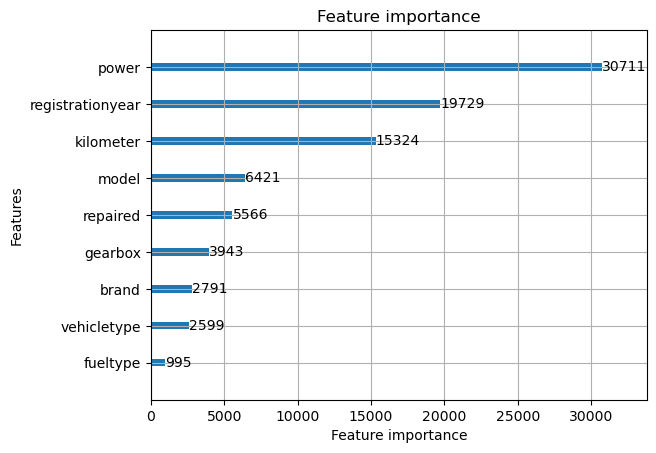

In [92]:
lgb.plot_importance(model_lgdb)
plt.show()

Как видно из графика, мощность двигателя, год регистрации (=возраст) и пробег являются определяющими для модели, что в целом интуитивно понятно для пользователя. При этом такие показатели как тип топлива, тип двигателя и бренд в целом можно считать вносящими несущественный вклад. Попробуем в связи с указанным уменьшить количество признаков, удалив тип топлива и обучив модель заново.

In [93]:
features_train_imp = features_train.drop(['fueltype'], axis = 1)

In [94]:
%%time
learning_boost(
    model_name = "LGBM",
    empty_model= lgb.LGBMRegressor(random_state=RANDOM_STATE),
    parametrs = {
        'n_estimators':range (100,500,50),
        'max_depth':(3,12),
        'num_leaves':(6,4096),
        'learning_rate':(0.001,0.1)
    },
    features = features_train_imp,
    target = target_train
    )

RMSE модели LGBM на тренировочной выборке:1487.69
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 12, 'n_estimators': 250, 'num_leaves': 4096}
Среднее время обучения модели 4.45 секунд
Среднее время получения величины ошибки 1.25 секунд
Saved grid LGBM search pipeline to file: best_estimator.pkl
CPU times: user 37.5 s, sys: 5.43 s, total: 42.9 s
Wall time: 3min 58s


Качество модели ухудшилось, в связи с чем мы не будем сохранять ее и воспользуемся моделью, обученной на полном наборе признаков.

### Дефолтная модель по среднему

В конце сравним наши вычисления с дефолтной моделью по медиане.

In [95]:
start = time.time()
dummy_reg = DummyRegressor(strategy='median')

dummy_reg.fit(features_train_ohe,target_train)
predicted_train = dummy_reg.predict(features_train_ohe)
result = mse(target_train, predicted_train)**0.5

end = time.time() - start
print("RMSE дефолтной модели регрессии на тренировочной выборке:{:.2f}".format(result))
print("Среднее время обучения модели:{:.1f}".format(end), "секунд")

RMSE дефолтной модели регрессии на тренировочной выборке:4895.59
Среднее время обучения модели:0.0 секунд


Итак, показатель отклонения по дефолтной медианной модели в 2-2,5 раза хуже, чем соответствующие показатели по любой из обученных моделей, соответственно, наши модели, как минимум, имеют смысл даже с текущей величиной ошибки.

По итогу рассмотрения всех вариантов модели остановимся на LGBM, она получила один из самых лучших результатов при большей скорости обработки данных.

## Анализ моделей

Проверим результат наилучшей LGBM на тестовой выборке.

In [96]:
model_LGBM = joblib.load('model_lgbm.pkl')

In [97]:
for c in cat_features:
    features_test[c] = features_test[c].astype('category')

In [98]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74419 entries, 299743 to 122103
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   vehicletype       74419 non-null  category
 1   registrationyear  74419 non-null  int64   
 2   gearbox           74419 non-null  category
 3   power             74419 non-null  float64 
 4   model             74419 non-null  category
 5   kilometer         74419 non-null  int64   
 6   fueltype          74419 non-null  category
 7   brand             74419 non-null  category
 8   repaired          74419 non-null  category
dtypes: category(6), float64(1), int64(2)
memory usage: 2.8 MB


In [99]:
predicted_test = model_LGBM.predict(features_test)

print("RMSE модели LGBM на тренировочной выборке:{:.2f}".format(mse(target_test, predicted_test)**0.5))

RMSE модели LGBM на тренировочной выборке:1442.96


Как всегда, сравним с дефолтной моделью.

In [100]:
start = time.time()
predicted_test = dummy_reg.predict(features_test)
result = mse(target_test, predicted_test)**0.5

end = time.time() - start
print("RMSE дефолтной модели регрессии на тренировочной выборке:{:.2f}".format(result))
print("Среднее время обучения модели:{:.1f}".format(end), "секунд")

RMSE дефолтной модели регрессии на тренировочной выборке:4903.44
Среднее время обучения модели:0.0 секунд


**Итого полученная модель работает достаточно быстро (время обучения 2,5 секунды, время расчета величины ошибки - 0,44 секунд, время подбора всех параметров через gridseargh - ок.половины минуты), точность модели гораздо выше запроса заказчика (1442 евро против 2500 евро). Таким образом, для текущих целей полученная модель LGBM подходит наилучшим образом.**

# Вывод
Нам удалось получить модель с ошибкой в 1,5 раза меньше целевой ошибки, обозначенной заказчиком, при этом скорость обучения достаточно высокая (менее 3х секунд), что также важно для внедрения и решения текущих бизнес-задач.